# Error analysis
Let's see where the text-only model and the reader-aware models differed, and where some outperformed others.

In [1]:
import gzip
text_only_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_token_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_attn_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_text_embed_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_text_embed_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
reader_subreddit_embed_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_subreddit_embed_data/test_data_sample_top_p=0.9_temperature=1.0_output_text.gz', 'rt')))
print(len(text_only_output))
print(len(reader_token_output))
print(len(reader_attn_output))
print(len(reader_text_embed_output))
print(len(reader_subreddit_embed_output))

59273
59273
59273
59273
59273


In [2]:
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt')
print(len(test_data))

59273


In [3]:
## combine everything lol
import pandas as pd
combined_data = pd.DataFrame([
    text_only_output,
    reader_token_output,
    reader_attn_output,
    reader_text_embed_output,
    reader_subreddit_embed_output,
    test_data['source_text'],
    test_data['target_text'],
    test_data['reader_token_str'],
    test_data['author_has_subreddit_embed'],
    test_data['author_has_text_embed'],
    test_data['article_id'],
], index=['text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output', 'source_text', 'target_text', 'reader_token', 'author_has_subreddit_embed', 'author_has_text_embed', 'article_id']).transpose()
print(combined_data.shape)
display(combined_data.head())

(59273, 11)


,text_only_output,reader_token_output,reader_attn_output,reader_text_embed_output,reader_subreddit_embed_output,source_text,target_text,reader_token,author_has_subreddit_embed,author_has_text_embed,article_id
0,Are all your fans spinning?,Are all your fans spinning?,What do you mean by this?,Do you have a job and a place to live once you...,Do you have an emergency fund of 3-6 months of...,"Hi all,I am running a Samsung 960 Evo on my z3...",Or did you put it in the other slot?,UNK,True,True,8ilzee
1,What the hell is wrong with you people?,What the hell is wrong with you people?,What the hell is wrong with you?,Do you have any family or friends who could he...,How old are you?,I own a pub/bar one of many in this highly pop...,The fuck is wrong with you?,UNK,False,False,csdb4t
2,Does she want to be involved in your life anym...,Does she have any right to see you or your fee...,Do you have any other relatives or other famil...,Do you have an emergency fund?,How is this even a question?,My mom left my dad when I was 17 (I’m 29 now) ...,Did you have play dates and supervised visits ...,UNK,False,False,bnr2gy
3,Does she work or just stay at home?,Does your wife work or just stay at home?,Why do people bother eating meat at school whe...,Do you have an emergency fund of 3-6 months of...,"NTA, what the hell is wrong with these people?","Dad here, old fart, loves his daughter to piec...",Is everything in the house paid for by her?,UNK,False,False,dkqv29
4,INFO: What is your issue with not inviting his...,INFO: What is your issue with gay people?,Do you want a wedding or do you just want a ma...,Do you have any other family members or friend...,What are you going to do about it?,My fiancé and I are a few months into planning...,Are your fiance's family aware that your broth...,UNK,False,False,b6yovf


In [4]:
## add subreddit data
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', index_col=False, usecols=['id', 'subreddit'])
post_data.rename(columns={'id' : 'article_id'}, inplace=True)
if('subreddit' not in combined_data.columns):
    combined_data = pd.merge(combined_data, post_data, on='article_id', how='left')

Compute BLEU-1 scores for all pairs of questions and test data.

In [5]:
## TODO: tokenize lol
from tqdm import tqdm
tqdm.pandas()
from model_helpers import compute_text_bleu
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
bleu_weights = [1.0, 0., 0., 0.]
model_output_cols = list(filter(lambda x: x.endswith('_output'), combined_data.columns))
combined_data = combined_data.assign(**{
    'target_text_tokens' : combined_data.loc[:, 'target_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
})
for model_output_col in model_output_cols:
    combined_data = combined_data.assign(**{
        f'{model_output_col}_tokens' : combined_data.loc[:, model_output_col].apply(lambda x: tokenizer.tokenize(x.lower()))
    })
    combined_data = combined_data.assign(**{
        f'{model_output_col}_BLEU' : combined_data.progress_apply(lambda x: compute_text_bleu(x.loc[f'{model_output_col}_tokens'], x.loc['target_text_tokens'], weights=bleu_weights), axis=1)
    })

  0%|          | 0/59273 [00:00<?, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overl

In [6]:
pd.set_option('display.max_colwidth', 1000)
model_text_1 = 'text_only_output'
model_text_2 = 'reader_token_output'
top_k = 10
for subreddit_i, data_i in combined_data.groupby('subreddit'):
    print(f'{model_text_1} vs. {model_text_2}: subreddit={subreddit_i}')
    data_i = data_i.assign(**{
        'BLEU_diff' : data_i.loc[:, f'{model_text_2}_BLEU'] - data_i.loc[:, f'{model_text_1}_BLEU']
    })
    data_i.sort_values('BLEU_diff', inplace=True, ascending=False)
    print(f'{model_text_2} > {model_text_1}')
    display(data_i.loc[:, ['source_text', 'target_text', model_text_1, f'{model_text_1}_BLEU', model_text_2, f'{model_text_2}_BLEU', 'reader_token']].head(20))
    print(f'{model_text_1} > {model_text_2}')
    data_i.sort_values('BLEU_diff', inplace=True, ascending=True)
    display(data_i.loc[:, ['source_text', 'target_text', model_text_1, f'{model_text_1}_BLEU', model_text_2, f'{model_text_2}_BLEU', 'reader_token']].head(20))

text_only_output vs. reader_token_output: subreddit=Advice
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
41938,"Around this time of year last year, my mom and two sisters moved to texas. Long story short, the stay was progressively getting worse.We stay with our great aunt and she doesn't make things very enjoyable. Because of her attitude and the things she says to our face but how she switches over the phone, we distance ourselves from her.On monday, she sent out a text saying that there are no babies in the house and that we need to fend for ourselves. But just yesterday, she said she would punish for a month because the siblings and I are not responding to her texts where no appropriate response can be given or one isn't needed. If we aren't babies, why do you have to punish us as if we are some?Our mom is trying to work to get a place of her own, but her being a single mom and having to deal with the three of us is hard.That example up there with my aunt is just the start. There have been other things said verbally and through text. She even tried to force her religion on us at one poin...",How old are you?,Is there a trusted teacher or school counselor you can talk to?,0.080759,How old are you?,1.000000,<RESPONSE_TIME_1_AUTHOR>
54455,"I was told the house was in a different city, had more people living in it, haf ti wait over a month longer than I was told id need to to move in, and was constantoy made to feel uncomfortable by the renters flirting with me. Was the only place I could afford. Been here for two weeks and am being asked to move out at the end of the minth because they randomly decided they were going to move. Should I ask for my money back that I paid as rent at the beginning of the month or would that be too out of line?",What money did you pay?,What did they say when you told them you wanted to move out?,0.175731,What money back did you pay?,0.846482,<RESPONSE_TIME_1_AUTHOR>
18501,"she wants to be on her laptop all day playing maplestory, and i'm literally just bored on my own laptop clicking around waiting for her to uhm, idk, finish up playing? so i tell her to stop playing, i feel ignored, after 6 hours, and she says she feels really bothered that i'm still on my laptop when i told her to get off of hers. so i get off of mine and then we just sit there.?????",How old are you two?,"Did she want you to sit there for her, or did you want her to?",0.053293,"Also, how old are you?",0.705401,<RESPONSE_TIME_1_AUTHOR>
18500,"she wants to be on her laptop all day playing maplestory, and i'm literally just bored on my own laptop clicking around waiting for her to uhm, idk, finish up playing? so i tell her to stop playing, i feel ignored, after 6 hours, and she says she feels really bothered that i'm still on my laptop when i told her to get off of hers. so i get off of mine and then we just sit there.?????",How old are you two?,"Did she want you to sit there for her, or did you want her to?",0.053293,INFO: how old are you?,0.705401,<EXPERT_PCT_0_AUTHOR>
23234,"Hey,I’m in desperate need of some advice. A mouse has died in the wall of a cupboard and cannot be removed. The smell is awful and it’s very close to food products. We’ve tried using special odour neutralising sachets but they’ve done nothing and only provided another bad smell. What sort of things can we do in this situation? We keep the cupboard door open as much as we can to aerate the area but I’m concerned it’s going to take a while for the mouse to fully decompose. Would love any advice as this is a very unpleasant smell. Thanks,Kikko",Have you tried coffee grounds?,Have you tried a new cupboard that’s quieter and it doesn’t smell like anything?,0.076373,Have you tried baking soda?,0.666667,<EXPERT_PCT_1_AUTHOR>
20499,I got enough money to go on a plan with the iPhone 11 Pro. I got 696 dollars and it’s 72 dollars a month over the course of 2 years paying it off. I got a job so I can keep putting money in my account and I don’t spend m

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
19193,"Well basically I moved to a new school in the middle of the year and I'm terrified to talk to anyone, but Im really lonely. How do I get people to like me?",What do you like?,What do you like?,1.000000,Or do you have a job where you're around other people?,0.099179,<EXPERT_PCT_0_AUTHOR>
57621,"I was laying in bed trying to fall asleep, when i thought about how people regret wasting their childhood doing stupid shit. I am currently in a pretty weird stage of life and just want to get some advice on what i should do, so that I don’t regret it in the future. I know it might sound cringe, but honestly i feel like my life doesn’t have a purpose...",How old are you?,How old are you?,1.000000,What kind of life do you want to have?,0.147152,<RESPONSE_TIME_0_AUTHOR>
19290,"Sorry this is rambly, I’m on mobile and I’m kind of just thought-vomiting.So my boyfriend (18) and I (18) have been dating just over a year now. Let me preface this by saying, I care about him a lot. He’s hands down the genuinely nicest person I know. But lately I’ve felt a little ignored, and there are some things that have bothered me for a while that are starting to be hard to ignore. He’s very immature. He has the sense of humor of a 13 hear old. He and his friend “Derek” make Youtube videos with Pokemon figures. And whenever his friends are around it’s like I’m invisible. He never invites me to hang out with him and his friends, and if I am ever in a group with him he totally ignores me. He also has really bad time management skills. He’s always, always late. We’ve missed a lot of movies and reservations in the past. He always apologizes but it never changes. And more than once he’s promised to pick me up from somewhere, and then when he’s supposed to be there to get me he’ll ...",Do you love him?,Do you still love him?,0.818731,What kind of person would be upset with you for not wanting to be around someone that is 10+ years older than you?,0.007326,<RESPONSE_TIME_1_AUTHOR>
19289,"Sorry this is rambly, I’m on mobile and I’m kind of just thought-vomiting.So my boyfriend (18) and I (18) have been dating just over a year now. Let me preface this by saying, I care about him a lot. He’s hands down the genuinely nicest person I know. But lately I’ve felt a little ignored, and there are some things that have bothered me for a while that are starting to be hard to ignore. He’s very immature. He has the sense of humor of a 13 hear old. He and his friend “Derek” make Youtube videos with Pokemon figures. And whenever his friends are around it’s like I’m invisible. He never invites me to hang out with him and his friends, and if I am ever in a group with him he totally ignores me. He also has really bad time management skills. He’s always, always late. We’ve missed a lot of movies and reservations in the past. He always apologizes but it never changes. And more than once he’s promised to pick me up from somewhere, and then when he’s supposed to be there to get me he’ll ...",Do you love him?,Do you still love him?,0.818731,What kind of person would be interested in talking to their nephew about something that happened 10+ years ago?,0.008152,<EXPERT_PCT_1_AUTHOR>
26725,"Currently I have a pretty bad trait which I am trying to overcome and change. However I'm finding it difficult to move past it. I find that if I am not instantly good at it, I lose interest very quickly or find it hard to keep that motivation going. It's really annoying because I want to learn new languages, new skills and generally just improve myself.What do you find helps overcome these issues? How do I maintain focus?",What is the trait?,What trait is it?,0.800000,Have you tried Rosetta Stone software?,0.134064,<EXPERT_PCT_0_AUTHOR>
22067,"Would it be ethical to be vegetarian in a non-vegetarian working class household. I'm a vegetarian but I can't afford to buy most of my own 

text_only_output vs. reader_token_output: subreddit=AmItheAsshole
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
49681,"Hello again AITA, you guys have previously weighed in on the long running battle between me and my sister so I figured I'd turn to you again to see if I really messed up. I'm always on my family's bad side so I appreciated the neutral input last time.Somehow it's become a tradition in my family that one family member host a Friday night dinner once a month. Last night was my night. My oldest sister and I have not been speaking since our vacation (click on user name to see why if you're curious) and I was able to avoid her at the January and February dinner at other's houses. I really, really didn't want her in my apartment. So I decided since she hates spicy food and her kids are allegedly allergic to peanuts, I could side step the issue and make this Thai peanut noodle dish that I love. I announced it well in advance in the group email what I was planning. Well since my sister is much more diabolical than I give her credit for, she had her husband drive the 2 hours to my place, f...",What is wrong with you?,"NTA, what sort of person takes someone else's pet and wants to eat their own food?",0.032324,What is wrong with you?,1.000000,<NONUS_AUTHOR>
49682,"Hello again AITA, you guys have previously weighed in on the long running battle between me and my sister so I figured I'd turn to you again to see if I really messed up. I'm always on my family's bad side so I appreciated the neutral input last time.Somehow it's become a tradition in my family that one family member host a Friday night dinner once a month. Last night was my night. My oldest sister and I have not been speaking since our vacation (click on user name to see why if you're curious) and I was able to avoid her at the January and February dinner at other's houses. I really, really didn't want her in my apartment. So I decided since she hates spicy food and her kids are allegedly allergic to peanuts, I could side step the issue and make this Thai peanut noodle dish that I love. I announced it well in advance in the group email what I was planning. Well since my sister is much more diabolical than I give her credit for, she had her husband drive the 2 hours to my place, f...",What is wrong with you?,"NTA, what the fuck is wrong with your family that they even speak to her like that?",0.095466,What is wrong with you?,1.000000,<EXPERT_PCT_0_AUTHOR>
49683,"Hello again AITA, you guys have previously weighed in on the long running battle between me and my sister so I figured I'd turn to you again to see if I really messed up. I'm always on my family's bad side so I appreciated the neutral input last time.Somehow it's become a tradition in my family that one family member host a Friday night dinner once a month. Last night was my night. My oldest sister and I have not been speaking since our vacation (click on user name to see why if you're curious) and I was able to avoid her at the January and February dinner at other's houses. I really, really didn't want her in my apartment. So I decided since she hates spicy food and her kids are allegedly allergic to peanuts, I could side step the issue and make this Thai peanut noodle dish that I love. I announced it well in advance in the group email what I was planning. Well since my sister is much more diabolical than I give her credit for, she had her husband drive the 2 hours to my place, f...",What is wrong with you?,"NTA, what the fuck is she doing with her pearls?",0.245253,What is wrong with you?,1.000000,<RESPONSE_TIME_0_AUTHOR>
51147,"ThrowawayOkay, I have a two-month-old and am currently on paternity leave. I’m fortunate to work at a place that’s family-oriented and where I’m a senior employee. I’m able to get a longer than typical paternity leave by working remotely from home. However, I had to go into the office to get documents that could only be accessed on my work computer. I thought I woul

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
2120,"Ever since I was young, all I could ever remember of my father was having really high expectations of me (but only with regards to things that he was interested in, like golf, physical activity and carpentry), and that he would always yell and scream at me and fight with my mother over the stupidest things.All my life I was walking on eggshells around him, because anything I said or did could be interpreted as an offence to him. Not breathe hard enough after a run? Clearly I'm doing something wrong; scream. Pick the cucumbers out of a sandwich he made for me? Clearly I'm ungrateful; scream. Adding the ingredients to soup in a different order than he showed me? Clearly I'm being defiant and disrespecting him; scream.And this wasn't even like just scream explosively for a few minutes. He would rant for fucking hours about the same stuff, twisting and warping my words and actions and never letting me get a chance to explain or defend myself. And of course, I would just stand there and...",How old are you?,How old are you?,1.000000,What's your reason for not talking to him anymore?,0.049319,UNK
58874,"Ok....so my parents are in a shitty situation. Basically my dad's a bit of a psycho and treats my mom poorly. This time however, she was the one making a mistake, even though it kinda was his fault.....i won't get into detail here. Now he acts as if he is a victim of her being psycho. He won't talk to her at all and when he does it's only to insult her, even though she said she's sorry a thousand times.Yesterday after she was done with her work shift, she called me and said that all trains are cancelled due to someone standing on the rails. She says she's going to use the tube but asks me to ask my father if he can come get her with a car from the station because it is raining heavily. I ask him, he finds a cheap excuse saying he drank a beer and can't. I ask him again saying it's raining. ""No"".So I tell her to take a cab from where she's getting off the tube and i'll come out the house and pay the ride as she didn't have any money.She wanted me to ask my father again but I knew he...",Info: how old are you?,INFO: How old are you?,1.000000,"Also, how does she have a bf if she has been depressed for a few weeks?",0.059357,<NONUS_AUTHOR>
58876,"Ok....so my parents are in a shitty situation. Basically my dad's a bit of a psycho and treats my mom poorly. This time however, she was the one making a mistake, even though it kinda was his fault.....i won't get into detail here. Now he acts as if he is a victim of her being psycho. He won't talk to her at all and when he does it's only to insult her, even though she said she's sorry a thousand times.Yesterday after she was done with her work shift, she called me and said that all trains are cancelled due to someone standing on the rails. She says she's going to use the tube but asks me to ask my father if he can come get her with a car from the station because it is raining heavily. I ask him, he finds a cheap excuse saying he drank a beer and can't. I ask him again saying it's raining. ""No"".So I tell her to take a cab from where she's getting off the tube and i'll come out the house and pay the ride as she didn't have any money.She wanted me to ask my father again but I knew he...",Info: how old are you?,INFO: How old are you?,1.000000,"Also, does she have mental illness?",0.123840,<RESPONSE_TIME_1_AUTHOR>
58875,"Ok....so my parents are in a shitty situation. Basically my dad's a bit of a psycho and treats my mom poorly. This time however, she was the one making a mistake, even though it kinda was his fault.....i won't get into detail here. Now he acts as if he is a victim of her being psycho. He won't talk to her at all and when he does it's only to insult her, even though she said she's sorry a thousand times.Yesterday after she was done with her work shift, s

text_only_output vs. reader_token_output: subreddit=legaladvice
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
20203,"Alright Reddit, first post, long time lurker. I'll try to keep this brief, but I have a situation.Over the course of several months, occasionally I would spend the evening at this apartment complex. Now, on more than one occasion (4,to be exact) I came out in the morning to my driver door vandalized. Only the driver door, as though I was being targeted. This happened over the course of several months and got progressively worse.I got smart, and bought a dashcam, because my car is important to me, and I take enough pictures of it to have documentation of the progression of the damage over the course of that time. Well, the dumbfuck came by again, at 5am, and I got him pretty clearly on camera. (Vantrue N2 Pro, for those curious). My lady friend recognizes him as her baby daddy, and former live-in boyfriend. They have been broken up for some time, but hes still hung up on her, bringing her gifts, trying to engage in manipulative behavior, trying to get her back or control her or what...","Or is that another claim, with another $500 deductible?",You say that you’re legal in WA but would you like to sue the person if they did this?,0.072433,"Or is that claim, with another $500 deductible?",0.916667,<EXPERT_PCT_1_AUTHOR>
20204,"Alright Reddit, first post, long time lurker. I'll try to keep this brief, but I have a situation.Over the course of several months, occasionally I would spend the evening at this apartment complex. Now, on more than one occasion (4,to be exact) I came out in the morning to my driver door vandalized. Only the driver door, as though I was being targeted. This happened over the course of several months and got progressively worse.I got smart, and bought a dashcam, because my car is important to me, and I take enough pictures of it to have documentation of the progression of the damage over the course of that time. Well, the dumbfuck came by again, at 5am, and I got him pretty clearly on camera. (Vantrue N2 Pro, for those curious). My lady friend recognizes him as her baby daddy, and former live-in boyfriend. They have been broken up for some time, but hes still hung up on her, bringing her gifts, trying to engage in manipulative behavior, trying to get her back or control her or what...","Or is that another claim, with another $500 deductible?","If you do, what is the legal question here?",0.250000,"Or is that claim, with another $500 deductible?",0.916667,<RESPONSE_TIME_1_AUTHOR>
35236,"Located in IAYoungest daughter is POA for grandfather. A will from 2008 shows everything split equally between all children of his with his signature. Within the next few years he fell victim to severe dementia and no longer even knew who his family members were. The POA somehow got a lawyer to draft a new will leaving her with everything (over $1 Million in value) and the other siblings with very little. I have yet to see the actual will, but if the grandfather signed wouldn't contract law easily void the will based on the fact that he is not of sound mind? If the POA was the one who signed the document couldn't it easily be said that she wasn't handling financial transactions for the grandfather, but rather for her own personal interest and void the will?&amp;#x200B;Is there a specific type of lawyer that should be engaged?",Have you seen this new will?,Is the POA still in probate?,0.142857,Have you seen the will?,0.714286,<RESPONSE_TIME_1_AUTHOR>
35235,"Located in IAYoungest daughter is POA for grandfather. A will from 2008 shows everything split equally between all children of his with his signature. Within the next few years he fell victim to severe dementia and no longer even knew who his family members were. The POA somehow got a lawyer to draft a new will leaving her with everything (over $1 Million in value) and the other siblings with very little. I have yet to see the actual will, but if t

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
58415,"I live in New Jersey, I’m currently 15 years old and live with my sister and abusive mother. She has driven my father out of the house and caused him to live somewhere else. This abuse and neglect has been going on for years and I, very obviously, need to leave. I turn 16 in September and would like to leave, my question is, generally, how would I go about getting emancipated successfully. What kind of questions do they ask and how could I answer these questions in the best way possible? Another concern I have is if a lawyer is worth it, and will help with my case. I would also like to start filing now since I know it takes months but do I have to wait until I’m 16 to start? Any help Is appreciated",Do you have a job?,Do you have a job?,1.000000,First question: do you have any info on what you’d need to do to get emancipated?,0.064648,<RESPONSE_TIME_1_AUTHOR>
58414,"I live in New Jersey, I’m currently 15 years old and live with my sister and abusive mother. She has driven my father out of the house and caused him to live somewhere else. This abuse and neglect has been going on for years and I, very obviously, need to leave. I turn 16 in September and would like to leave, my question is, generally, how would I go about getting emancipated successfully. What kind of questions do they ask and how could I answer these questions in the best way possible? Another concern I have is if a lawyer is worth it, and will help with my case. I would also like to start filing now since I know it takes months but do I have to wait until I’m 16 to start? Any help Is appreciated",Do you have a job?,Do you have a job?,1.000000,First question: do you have a court date already?,0.362165,<EXPERT_PCT_0_AUTHOR>
50125,"I live in the United States. I am 21 years old, and i got a letter saying that from the time i was 10-13 years old my dad overpaid in child support and that I am being held responsible for it, they are demanding $10,000 and are threatening to go into my bank account and taking the money from me. My first question is *WHAT THE FUCK*My second question is how is it legal to hold a 10-13 year old responsible for this like wtf is going on.",What are you paying?,What state are you in?,0.654985,"What's the letter or notice number, identified in the upper right corner of page one?",0.024324,<EXPERT_PCT_0_AUTHOR>
15243,"We got divorced 5 years ago. it was a ""good"" divorce. She got the house and her things i got my car and my things. it was pretty straight forward. She eventually took me to court last year because of late payments on my car, she cosigned. She took me to court for contempt because it was hurting her credit. I tried refinancing the car several times but couldn't because my name was on the house. I finally got it done. But now i want to get a house or some land to build on. I'm still on the house loan and she has re-married. What would be the best way to go about handling this? I have a good job now and get paid well but having over 100k of debt still in my name isnt going to help me at all despite her having the house and responsibility of payments. Im not sure who i need to talk to as far as what type of lawyer or anything.",Did you have a divorce attorney?,Did you have an attorney for the divorce?,0.644123,What is your income and what are your other debts?,0.080674,<RESPONSE_TIME_1_AUTHOR>
15242,"We got divorced 5 years ago. it was a ""good"" divorce. She got the house and her things i got my car and my things. it was pretty straight forward. She eventually took me to court last year because of late payments on my car, she cosigned. She took me to court for contempt because it was hurting her credit. I tried refinancing the car several times but couldn't because my name was on the house. I finally got it done. But now i want to get a house or some land to build on. I'm still on the house loan and she h

text_only_output vs. reader_token_output: subreddit=pcmasterrace
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
37360,"Hi, recently i noticed that my pc i built a while back has been behaving in a strange way. In order of first occurrence:* Every so often it would bluescreen. (I tossed this up to windows 10 being windows 10)* I'd come home to see my pc off (presumably it BSOD'd while i was away)* Games started crashing without errors (fine one minute, on the desktop the next, no warning or stuttering)* Apps, specifically their GUI started acting weird. (chrome's top bar would go black and flicker on only one window, always and ONLY the window that was on the leftmost monitor when it started)* Weird artifacting would start on games running on my leftmost monitor. (strange green patterns flashing. went away after resizing window)* Games, specifically KSP, would crash on load, or improperly load. (certain parts were missing or had the incorrect model assigned)* I think this is either a ram thing or a gpu think. Leaning to GPU because most of the symptoms are graphics or game related, but i'm not sure....",How old is your windows installation?,Do you try turning it off and on again?,0.093063,How old is your Windows installation?,1.000000,<RESPONSE_TIME_0_AUTHOR>
26074,How long will my i5 4690 and rx570 4gb last me for gaming? Should I upgrade this year or wait it out?,What games do you play?,What is your budget and what are you trying to get it for?,0.131799,What games do you play?,1.000000,<RESPONSE_TIME_0_AUTHOR>
49234,"Having a hard time deciding on which graphics card to get for my build. Both cards are being sold locally on Kijiji, the 1070 is 350$CAD (Gigabyte Windforce OC), and the 1070ti is 450$CAD (Asus Strix). Is the Ti worth it for maybe 10-15% more power?",What is your budget?,Do you live in the US?,0.134064,What is your budget?,1.000000,<EXPERT_PCT_0_AUTHOR>
26072,How long will my i5 4690 and rx570 4gb last me for gaming? Should I upgrade this year or wait it out?,What games do you play?,What is your budget and what resolution are you playing at?,0.183940,What games do you play?,1.000000,<US_AUTHOR>
26073,How long will my i5 4690 and rx570 4gb last me for gaming? Should I upgrade this year or wait it out?,What games do you play?,What is your current GPU and ram?,0.238844,What games do you play?,1.000000,<EXPERT_PCT_0_AUTHOR>
36979,Whenever I try to record rocket league gameplay with OBS the recording comes up corrupted [(as seen in here)](https://youtu.be/Skxzisg_Tm0) .Here's my OBS [video settings](https://i.imgur.com/ZsmWS13.png),What are your hardware specs?,Is that the OBS recording or just OBS?,0.101088,What are your specs?,0.833333,<RESPONSE_TIME_1_AUTHOR>
46849,Just wondering whether I will be sacrificing performance by going with an AMD cpu over an intel one and what GPU to buy for 60+FPS on some AAA titles.... thanks heaps in advance,About what is your budget?,What games are you looking to play and at what resolution/refresh rate?,0.074377,What is your CPU?,0.666667,<RESPONSE_TIME_1_AUTHOR>
18494,"I recently added a Corsair cpu water cooler to my system but now my monitors are showing ""no signal"" in stumped. I only have 600 watts of power im guessing this could be the issue?",Is the cable plugged into the graphics card and not the motherboard?,what are the complete specs of the system?,0.230769,Is the water cooler plugged into the motherboard or the graphics card?,0.769231,<EXPERT_PCT_1_AUTHOR>
56110,"Ok so yeah might be wrong place, but r/applehelp are no help.Trying to force either boot in safe mode or boot with intel graphics on 2011 imac. For safe mode I tried 'sudo nvram something something' but not working. I can only find command line to boot with intel (not amd) graphics for macbook, which doesnt seem to work for imac.",Have you googled your question yet?,Is your computer plugged into a USB 3 port and is it connected to a USB 2.0 port?,0.038667,Have you tried updating your BIOS?,0.571429,<

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
55115,"Hello! I'm having some trouble with dolphin. Numerous games I've tried run at around 60% so there is stuttering and messed up audio. My is a dell inspiron 7577 with a 1060, 16GB of ram and an i7 7700HQ. I turned all the NVIDIA junk off, reinstalled the most recent one, and have tried all other suggestions for settings online. Temps dont get above 60. ANy ideas?Edit I remember my computer makes other games run at 40fps but idk if it still does. They aren't choppy tho",What are your Dolphin settings?,What are your graphics settings?,0.833333,How are you setting the timings on your cpu?,0.256709,<EXPERT_PCT_0_AUTHOR>
22638,"Dear Gaming PC community,I bought a PC for Destiny 2 Shadowkeep after Cross Save and I am moving from PS4. Up to now the experience has been a nightmare, it is my first gaming PC and it supposedly has more than enough specs but I have yet to play anything.I got a free copy of Control to test it and I have not been able to make it work.First the GPU was broken and had it replaced and now the launcher and the task manager marks the game is running but it is not. I have downloaded all the drivers, re-installed the game etc. I don’t know what else I should do.ThanksPD I am old and new on this Reddit thing",What other games have you tried?,What other hardware do you have?,0.714286,"What do you mean by ""refused to make it work""?",0.139869,<RESPONSE_TIME_1_AUTHOR>
22637,"Dear Gaming PC community,I bought a PC for Destiny 2 Shadowkeep after Cross Save and I am moving from PS4. Up to now the experience has been a nightmare, it is my first gaming PC and it supposedly has more than enough specs but I have yet to play anything.I got a free copy of Control to test it and I have not been able to make it work.First the GPU was broken and had it replaced and now the launcher and the task manager marks the game is running but it is not. I have downloaded all the drivers, re-installed the game etc. I don’t know what else I should do.ThanksPD I am old and new on this Reddit thing",What other games have you tried?,What other hardware do you have?,0.714286,"What do you mean by ""refused to make it work""?",0.139869,<EXPERT_PCT_0_AUTHOR>
22341,My monitor is the BenQ XL2540 obviously at 240hz in nvidia and windows settings. I have all the recommended settings on in nvcp and on the monitor. It kinda fricken blows. It’s been 4 months and I can’t fix it. Anything helps. Please. I’m begging.,you are using a Dp right?,What resolution are you using?,0.571429,How about the gpu : is it plugged into the motherboard or the graphics card?,0.039493,<EXPERT_PCT_1_AUTHOR>
23017,"Hello everyone, and thanks in advance for any help.I've been facing this issue since I upgraded to a Ryzen 2600 System back in Oct. 2018. At the time the build was as follows:Ryzen 5 26000 (overclocked at times, but issue persists at Stock as well)Cooled by a Cryorig H7 PlusMSI B450-A Plus (latest drivers at the time)16GB G.Skill 3000MHz RAMGigabyte Gaming G1 GTX 1070 (Up-to-date drivers)Corsair TX650mMy issue is that I cannot play games that use Anti Cheat services. This goes between BattleEye and EasyAntiCheat as far as I've tested. Across Origin or Steam. Games like Rising Storm 2, Apex Legends, 7 Days to Die, PUBG, Day of Infamy. These are all games I tested. Most of these I played on my previous system without issue (i5-4460, 12GB DDR3 RAM, same GPU and storage drives)What happens is when the game loads up, I get the initial splash, and when the AntiCheat tries to load, my PC blue screens, with consistent errors always referencing the same things.&gt; On Mon 2/4/2019 10:05:49 ...",Have you tried the obvious?,Have you tried overclocking your cpu?,0.564321,"Have you checked for other issues, cpu issues, gpu issues, any issues with any other cpu issues?",0.041042,<EXPERT_PCT_0_AUTHOR>
40630,I want to upgrade my Samsung monitor C24f390 for a 

text_only_output vs. reader_token_output: subreddit=personalfinance
reader_token_output > text_only_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
44048,"I'm considering a fairly standard 3% balance transfer, 0% APR for 12 months, for a balance of a few thousand. I would like to avoid opening a new card account just for this purpose, but my bank card is the one with a zero balance.Is there anything specific to bank credit cards that would make this a bad idea? For example, does the bank now know I have debt and won't give me a good rate on a hypothetical future car loan? Or, is it good the bank sees me paying that balance to zero so it actually improves my standing with them? Or, is it all irrelevant?By the way, I'm in this situation because a few life emergencies hit all at once last year, draining my emergency fund and still racking up this few thousand on a credit card. So, I'll be fine thanks to all the great advice I've read here. I just have this vague memory of reading a comment warning about balance transfers to a card at my own bank. Did I imagine that?","Or, is it all irrelevant?","Or, is it good the bank sees me paying that balance to zero so it actually improves my standing with them?",0.072644,"Or, is it all irrelevant?",1.000000,<RESPONSE_TIME_0_AUTHOR>
22478,"I'm 41 years old. Finally have a stable job with stable income and benefits. I'm married with one child and we live in California. I make 170k a year and the wife make 40k. I'm just starting to put away money through my 401k employer match. I have an extra 3 grand a month. After I max out my 401k at $19,000 and an IRA Roth at $6,000. What else can I max out for our retirement? Can I open two IRAs? Do I open one for me and one for my wife? Is it a joint account? Do I make too much to max out my 401k? The 19k limit for 401k, includes my employer match correct? Does the retirement account just stop accepting contributions once I hit the 19k or do I have to be on top of it? I have no knowledge of how to do this. I don't want to make a mistake and be penalized come tax time.What would you do if you had an extra 3 grand and no retirement. Thanks so much and my apologies for the dumb questions...",Is it a joint account?,What else can I max out for our retirement?,0.085570,Is it a joint account?,1.000000,<EXPERT_PCT_0_AUTHOR>
22479,"I'm 41 years old. Finally have a stable job with stable income and benefits. I'm married with one child and we live in California. I make 170k a year and the wife make 40k. I'm just starting to put away money through my 401k employer match. I have an extra 3 grand a month. After I max out my 401k at $19,000 and an IRA Roth at $6,000. What else can I max out for our retirement? Can I open two IRAs? Do I open one for me and one for my wife? Is it a joint account? Do I make too much to max out my 401k? The 19k limit for 401k, includes my employer match correct? Does the retirement account just stop accepting contributions once I hit the 19k or do I have to be on top of it? I have no knowledge of how to do this. I don't want to make a mistake and be penalized come tax time.What would you do if you had an extra 3 grand and no retirement. Thanks so much and my apologies for the dumb questions...",Is it a joint account?,What else can I max out for our retirement?,0.085570,Is it a joint account?,1.000000,<RESPONSE_TIME_1_AUTHOR>
9008,"Hi There,I'm writing to inquire about a hypothetical situation, and I mean an actual hypothetical situation where I'm alluding to an actual situation.I currently work for a company that has a plummeting stock price. As of today it's about $2.5 a share, but I do have have about a healthy amount of them. I have to wait about 4 more years to let them vest. However, I have two main questions about them.1) If the company were to be bought out, what would happen to my stocks? How does that affect the company's stock when it is bought out? 2) It's my understanding that I'm only taxed on income generated from increased stock prices, a la capital 

text_only_output > reader_token_output


,source_text,target_text,text_only_output,text_only_output_BLEU,reader_token_output,reader_token_output_BLEU,reader_token
58325,"Long story short my father is in the ICU in critical condition. We're not sure he's going to make it. I am hoping/praying for the best, but obviously, I would like to be prepared for the worst. If that does happen, he'll be survived by my mother (however her understanding of English is very limited, so she's relying on me).Some questions I have:\-My dad did create a will, however it is based in WA state and we are all presently in FL. Is there any concern for this?\-How does debt work? If a credit card was created in my dad's name alone, are my mom and I financially responsible? Does the same extend to a mortgage or even a loan?\-What are my next steps? Do I need to hire an attorney? If so what kind? I mean literally ANY and ALL advice/information/pointers/tips/younameit would be greatly appreciated.Thanks",Does the same extend to a mortgage or even a loan?,Does the same extend to a mortgage or even a loan?,1.000000,Is there any concern for this?,0.083333,<RESPONSE_TIME_1_AUTHOR>
19584,"So I am employed by a company making good money and so is my wife and we do typical taxes every year with a W-2 and that's it (we fall into 22% federal tax bracket). However, I am also seeking to pursue a side gig to make some extra money (about 30-45 an hour), but the way the company works, I would be a contractor with them (since I filled out a W-9 when I got the job). I am also now married and will have my first child in the coming weeks.I have a few questions that I'm hoping somebody might be able to answer for me.1. What will I now classify as when doing my taxes?2. How do the various incomes (salary from employer &amp; sole proprietor income) affect my tax returns?3. I have heard that sole proprietors pay extra taxes because of self employment taxes. Will I only pay those on the side gig income and then regular taxes on my salary income?4. Related to #3, people have told me that sometimes side gigs aren't worth it because of all the extra taxes. Does my situation seem like th...",Will I only pay those on the side gig income and then regular taxes on my salary income?,Did I only pay those on the side gig income and then regular taxes on my salary income?,0.947368,Did you already itemize your deductions?,0.052632,<EXPERT_PCT_0_AUTHOR>
26745,"I just got their cashback credit card recently (Canada) with a specific limit, and also the Gold card which is a charge card and therefore no “pre-set limit”.How do I know how much I can spend ?Also **if I apply for another (new) credit card while keeping my current** cashback card, **does my limit get distributed across both?** Or do I just get extra credit ?Also does this impact credit rating or anything",Or do I just get extra credit ?,Or do I just get extra credit?,1.000000,"What does ""pre-set"" mean?",0.110312,<RESPONSE_TIME_1_AUTHOR>
26744,"I just got their cashback credit card recently (Canada) with a specific limit, and also the Gold card which is a charge card and therefore no “pre-set limit”.How do I know how much I can spend ?Also **if I apply for another (new) credit card while keeping my current** cashback card, **does my limit get distributed across both?** Or do I just get extra credit ?Also does this impact credit rating or anything",Or do I just get extra credit ?,Or do I just get extra credit?,1.000000,What is the statement balance on the card?,0.110312,<EXPERT_PCT_1_AUTHOR>
20315,"Using a throwaway account because I royally messed up and am honestly incredibly embarrassed with myself.I am in serious need of help with the state of my traditional IRA and don’t know what to do and honestly don’t really understand things and am freaking out. Basically, I switched jobs in 2015 and decided to roll over my 401k into an IRA. I had contributed only Roth contributions to the 401k, but from my understanding at the time, my Roth 401k contributions could be rolled over 

Cases where `reader_token` model outperforms `text_only` model:
- `r/Advice`
    1. 
        - `post`: "Over the past week I’ve realized that I’m not interested in the majority of jobs that require a high school degree or more."
        - `target`: "What do you want to do?"
        - `text_only_output`: "Is there any way you could minor in computer science or software engineering at all?"
        - `reader_token_output` : "What do you want to do with your life?"
        - `reader_group` : `<RESPONSE_TIME_1_AUTHOR>`
- `r/AmITheAsshole`
    1. 
        - `post`: "A few months ago I made the decision that I am atheist. I have very Christian parents and I know they likely would be angry."
        - `target`: "Why do you need to tell them at all?"
        - `text_only_output`: "Are you an asshole for telling them?"
        - `reader_token_output` : "Why do you need to tell them at all?"
        - `reader_group` : `<EXPERT_PCT_0_AUTHOR>`
- `r/LegalAdvice`
    1. 
        - `post`: "Youngest daughter is POA for grandfather. A will from 2008 shows everything split equally between all children of his with his signature."
        - `target`: "Have you seen this new will?"
        - `text_only_output`: "Is the POA still in probate?"
        - `reader_token_output` : "Have you seen the will?"
        - `reader_group`: `<EXPERT_PCT_1_AUTHOR>`
- `r/PCMasterRace`
    1. 
        - `post`: "Hi, recently i noticed that my pc i built a while back has been behaving in a strange way. In order of first occurrence:* Every so often it would bluescreen. (I tossed this up to windows 10 being windows 10)* I'd come home to see my pc off (presumably it BSOD'd while i was away)* Games started c..."
        - `target`: "How old is your windows installation?"
        - `text_only_output`: "Do you try turning it off and on again?"
        - `reader_token_output` : "How old is your Windows installation?"
        - `reader_group`: `<RESPONSE_TIME_0_AUTHOR>`
- `r/PersonalFinance`
    1. 
        - `post`: "This may not be the proper forum to pose this question, but my wife needs around 20,000$ US in dental surgery."
        - `target`: "Do you have insurance?"
        - `text_only_output`: "Is there a government program or something that we can apply to?"
        - `reader_token_output` : "Do you have dental insurance?"
        - `reader_group`: `<NONUS_AUTHOR>`

Cases where `text_only` model outperforms `reader_token` model:

- `r/Advice`
    1. 
        - `post`: "Currently I have a pretty bad trait which I am trying to overcome and change. However I'm finding it difficult to move past it"
        - `target`: "What is the trait?"
        - `text_only_output`: "What trait is it?"
        - `reader_token_output` : "Have you tried Rosetta Stone software?"
        - `reader_group` : `<EXPERT_PCT_0_AUTHOR>`
- `r/AmITheAsshole`
    1. 
        - `post`: "I and my husband have been married for 7 years. We have 3 kids and I take care of them."
        - `target`: "How old are your kids?"
        - `text_only_output`: "How old are the kids?"
        - `reader_token_output` : "How much sleep does he get at night?"
        - `reader_group` : `<RESPONSE_TIME_0_AUTHOR>`
- `r/LegalAdvice`
    1. 
        - `post`: "We got divorced 5 years ago. it was a "good" divorce. She got the house and her things i got my car and my things."
        - `target`: "Did you have a divorce attorney?"
        - `text_only_output`: "Did you have an attorney for the divorce?"
        - `reader_token_output` : "What are the interest rates on the car loan?"
        - `reader_group`: `<EXPERT_PCT_0_AUTHOR>`
- `r/PCMasterRace`
    1. 
        - `post`: "I want to upgrade my Samsung monitor C24f390 for a bigger monitor with better refresh frecuency."
        - `target`: "What country, and what's your budget?"
        - `text_only_output`: "What's your budget for a new monitor?"
        - `reader_token_output` : "Is the graphic card really that big of an issue?"
        - `reader_group`: `<RESPONSE_TIME_1_AUTHOR>`
- `r/PersonalFinance`
    1. 
        - `post`: "Hi!23 years old hereSalary:100k (possibly more depending on how much OT I wanna work)"
        - `target`: "Are these taxes just accounted for every year?"
        - `text_only_output`: "Do these taxes just accounted for every year?"
        - `reader_token_output` : "How much do you make per year?"
        - `reader_group`: `<EXPERT_PCT_1_AUTHOR>`

### Compare questions: length
Do some models do better with longer/shorter questions?

In [7]:
combined_data = combined_data.assign(**{
    'target_text_len' : combined_data.loc[:, 'target_text_tokens'].apply(lambda x: len(x))
})

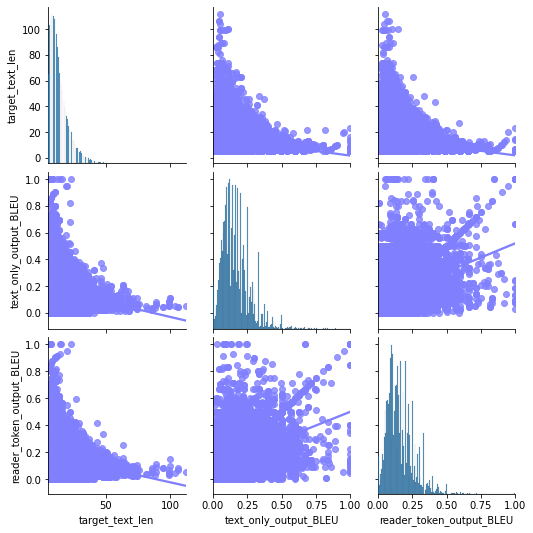

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(data=combined_data, vars=['target_text_len', 'text_only_output_BLEU', 'reader_token_output_BLEU'], kind='reg', plot_kws={'color' : (0.5, 0.5, 1.0, 0.25)})
plt.show()

Is there any consistent difference in the correlation between question length and model performance?

In [9]:
from scipy.stats import spearmanr, pearsonr
output_vars = ['text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
for output_var in output_vars:
    print(f'testing output = {output_var}')
    correl, p_val = spearmanr(combined_data.loc[:, 'target_text_len'].values, 
                              combined_data.loc[:, f'{output_var}_BLEU'].values)
    print(f'correl = {correl}, p={p_val}')

testing output = text_only_output
correl = -0.09486786266187161, p=1.5119364239892349e-118
testing output = reader_token_output
correl = -0.0871170205673492, p=3.331188496362848e-100
testing output = reader_attn_output
correl = -0.17248872263964374, p=0.0
testing output = reader_text_embed_output
correl = -0.020537382662875633, p=5.719288795463801e-07
testing output = reader_subreddit_embed_output
correl = -0.18086530289847677, p=0.0


In general, all models do worse on longer text. The correlation is less severe for the `reader_token` model than for others, except for `text_embed` model.

### Compare questions: type
Do some models do better with different types of questions (e.g. `how` vs. `why`)?

We need a good way to extract the question word from the subject position, so let's try parsing.

In [10]:
## get children of root word C
## check for valid relations: advmod, dobj, attr
## if none, check for determiners on NPs ("which one"): det, advmod
def get_question_modifiers(parser, sentence, question_words, 
                       question_word_deps={'advmod', 'dobj', 'attr', 'aux'}, determiner_deps={'det', 'advmod'},
                       determiner_attach_deps={'acomp', 'dobj', 'attr'}):
    sentence_parse = parser(sentence)
    sentence_root = list(sentence_parse.sents)[0].root
    root_children = list(sentence_root.children)
    # check for question words in immediate children
    modifier_children = list(filter(lambda x: x.dep_ in question_word_deps, root_children))
    question_modifiers = list(filter(lambda x: x.text.lower() in question_words, modifier_children))
    # check for question words in determiners on children
    if(len(question_modifiers) == 0):
        potential_det_parents = list(filter(lambda x: x.dep_ in determiner_attach_deps, root_children))
        det_children = [y for x in potential_det_parents for y in x.children if y.dep_ in determiner_deps]
        question_det_modifiers = list(filter(lambda x: x.text.lower() in question_words, det_children))
        question_modifiers += question_det_modifiers
    # lower-case everything
    question_modifiers = list(map(lambda x: x.text.lower(), question_modifiers))
    return question_modifiers

In [11]:
import spacy
test_sents = ['How many are there?', 'What is the problem?', 'You are going where?', 'And when are you leaving?']
parser = spacy.load('en_core_web_sm')
question_words = {'how', 'when', 'where', 'what', 'who', 'why', 'which', 'do', 'should', 'could', 'would', 'can'}
for sentence in test_sents:
    sentence_parse = parser(sentence)
    sentence_question_modifiers = get_question_modifiers(parser, sentence, question_words)
    print(sentence_question_modifiers)

['how']
['what']
['where']
['when']


In [12]:
from tqdm import tqdm
tqdm.pandas()
combined_data = combined_data.assign(**{
    'question_word' : combined_data.loc[:, 'target_text'].progress_apply(lambda x: get_question_modifiers(parser, x, question_words))
})
combined_data = combined_data.assign(**{
    'question_word' : combined_data.loc[:, 'question_word'].progress_apply(lambda x: x[0] if len(x) > 0 else 'other')
})
# get word counts
question_word_counts = combined_data.loc[:, 'question_word'].value_counts()
print(question_word_counts)

100%|██████████| 59273/59273 [00:00<00:00, 893338.58it/s]

other     36820
do         6796
what       4823
how        3688
why        2540
would      1625
can        1338
could       550
where       492
should      292
when        256
who          28
which        25
Name: question_word, dtype: int64


Let's see how the different models do on different questions!!

In [13]:
flat_data = pd.melt(combined_data, value_vars=['text_only_output_BLEU', 'reader_token_output_BLEU', 'reader_attn_output_BLEU', 'reader_text_embed_output_BLEU', 'reader_subreddit_embed_output_BLEU'], id_vars=['question_word'], var_name='model_type', value_name='BLEU')
flat_data = flat_data.assign(**{'model_type' : flat_data.loc[:, 'model_type'].apply(lambda x: x.replace('_BLEU', ''))})
display(flat_data.head())

,question_word,model_type,BLEU
0,other,text_only_output,0.100000
1,other,text_only_output,0.644123
2,other,text_only_output,0.238095
3,other,text_only_output,0.100000
4,other,text_only_output,0.230769


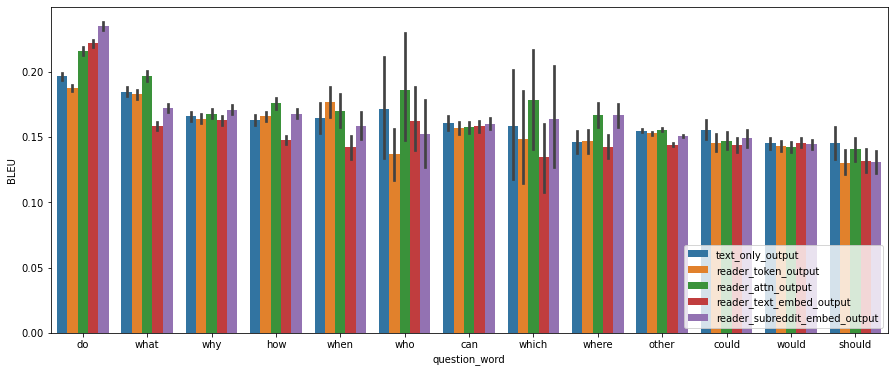

In [14]:
plt.figure(figsize=(15, 6))
sns.barplot(data=flat_data, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='lower right')
plt.show()

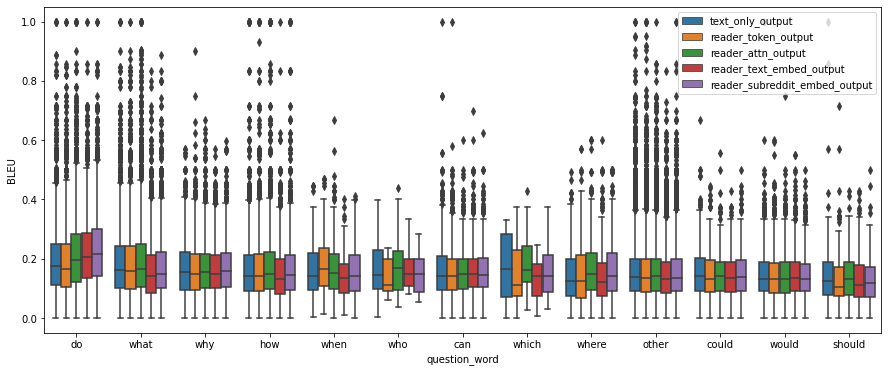

In [16]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=flat_data, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='upper right')
plt.show()

- All models do well on `do`, `what` questions and poorly on `would`, `should`.
- `text_only` model does better on `could`, `can`, `should` questions.
- `reader_token` model does slightly better `when` questions.
- `reader_attn_output` model does better on `what`, `where`, `who`, and `how` questions.
- `reader_text_embed` and `reader_subreddit_embed` models do (slightly) better on `do` and `where` questions.

Let's confirm this result with each type of model on the questions that actually have reader question information.

44888
0.757309398883134


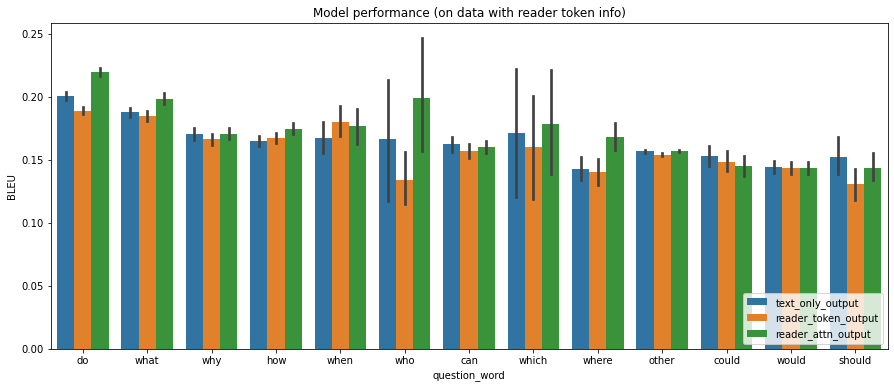

In [37]:
## reader token
combined_data_with_reader_token = combined_data[combined_data.loc[:, 'reader_token']!='UNK']
print(combined_data_with_reader_token.shape[0])
print(combined_data_with_reader_token.shape[0]/combined_data.shape[0])
## re-flatten data
flat_data_with_reader_token = pd.melt(combined_data_with_reader_token, value_vars=['text_only_output_BLEU', 'reader_token_output_BLEU', 'reader_attn_output_BLEU',], id_vars=['question_word'], var_name='model_type', value_name='BLEU')
flat_data_with_reader_token = flat_data_with_reader_token.assign(**{'model_type' : flat_data_with_reader_token.loc[:, 'model_type'].apply(lambda x: x.replace('_BLEU', ''))})
plt.figure(figsize=(15, 6))
sns.barplot(data=flat_data_with_reader_token, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='lower right')
plt.title('Model performance (on data with reader token info)')
plt.show()

28005
0.47247481990113543


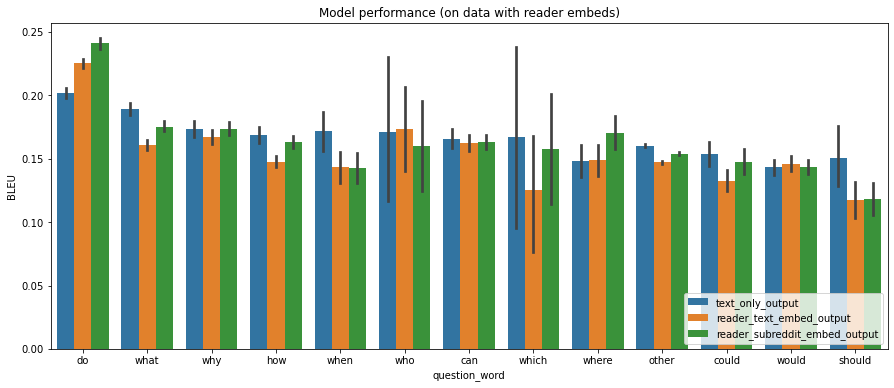

In [38]:
## reader embeds
combined_data_with_embed = combined_data[combined_data.loc[:, 'author_has_subreddit_embed'] & combined_data.loc[:, 'author_has_text_embed']]
print(combined_data_with_embed.shape[0])
print(combined_data_with_embed.shape[0]/combined_data.shape[0])
## re-flatten data
flat_data_with_embed = pd.melt(combined_data_with_embed, value_vars=['text_only_output_BLEU', 'reader_text_embed_output_BLEU', 'reader_subreddit_embed_output_BLEU'], id_vars=['question_word'], var_name='model_type', value_name='BLEU')
flat_data_with_embed = flat_data_with_embed.assign(**{'model_type' : flat_data_with_embed.loc[:, 'model_type'].apply(lambda x: x.replace('_BLEU', ''))})
plt.figure(figsize=(15, 6))
sns.barplot(data=flat_data_with_embed, x='question_word', y='BLEU', hue='model_type', order=sorted(flat_data.loc[:, 'question_word'].unique(), key=lambda x: flat_data[flat_data.loc[:, 'question_word']==x].loc[:, 'BLEU'].mean(), reverse=True))
plt.legend(loc='lower right')
plt.title('Model performance (on data with reader embeds)')
plt.show()

### Test question-post overlap
How much do the questions overlap with the post content?

We can measure this with two metrics:
1. max semantic overlap: find sentence with highest similarity (in sentence embedding) to question
2. topic overlap: compute topic distribution over all posts, compute overall topical alignment with post/question

### Post overlap: semantics

In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def compute_max_sent_overlap(post_text, question_text, sent_tokenizer, sentence_embed_model):
    post_text_sents = sent_tokenizer.tokenize(post_text)
    post_text_sent_embeds = np.array(list(map(lambda x: sentence_embed_model.encode(x), post_text_sents)))
    question_embed = sentence_embed_model.encode(question_text)
    post_text_sent_question_sims = cosine_similarity(post_text_sent_embeds, question_embed.reshape(1,-1))[:, 0]
    max_sim = post_text_sent_question_sims.max()
    max_sim_sent = post_text_sents[post_text_sent_question_sims.argmax()]
    return (max_sim_sent, max_sim)

In [18]:
from sentence_transformers import SentenceTransformer
from nltk.tokenize import PunktSentenceTokenizer
from tqdm import tqdm
tqdm.pandas()
sample_size = 5000
np.random.seed(123)
sample_combined_data = combined_data.loc[np.random.choice(combined_data.index, sample_size, replace=False), :]
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
# target_text_vars = ['target_text']
sentence_embed_model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sent_tokenizer = PunktSentenceTokenizer()
for target_text_var in target_text_vars:
    print(f'testing text={target_text_var}')
    sample_combined_data = sample_combined_data.assign(**{
        f'{target_text_var}_max_sim_sent' : sample_combined_data.progress_apply(lambda x: compute_max_sent_overlap(x.loc['source_text'],  x.loc[target_text_var], sent_tokenizer, sentence_embed_model), axis=1)
    })

  0%|          | 0/5000 [00:00<?, ?it/s]

testing text=target_text


  0%|          | 3/5000 [00:00<04:20, 19.18it/s]

testing text=text_only_output


  0%|          | 3/5000 [00:00<04:23, 19.00it/s]

testing text=reader_token_output


  0%|          | 3/5000 [00:00<04:22, 19.05it/s]

testing text=reader_attn_output


  0%|          | 3/5000 [00:00<04:24, 18.89it/s]

testing text=reader_text_embed_output


100%|██████████| 5000/5000 [08:50<00:00,  9.42it/s]


In [19]:
## separate sents and sim values
for target_text_var in target_text_vars:
    sample_combined_data = sample_combined_data.assign(**{
        f'{target_text_var}_max_sim_sent_val' : sample_combined_data.loc[:, f'{target_text_var}_max_sim_sent'].apply(lambda x: x[1]),
        f'{target_text_var}_max_sim_sent' : sample_combined_data.loc[:, f'{target_text_var}_max_sim_sent'].apply(lambda x: x[0]),
    })

What are some sentences with high post similarity?

In [56]:
max_sim_cutoff_val = 1-1e-3 # removing duplicates
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
for target_text_var_i in target_text_vars:
    # restrict to relevant data
    if(target_text_var in {'reader_token_output', 'reader_attn_output'}):
        sample_combined_data_i = sample_combined_data[sample_combined_data.loc[:, 'reader_token']!='UNK']
    elif(target_text_var in {'reader_text_embed_output', 'reader_subreddit_embed_output'}):
        sample_combined_data_i = sample_combined_data[sample_combined_data.loc[:, 'author_has_subreddit_embed'] & sample_combined_data.loc[:, 'author_has_text_embed']]
    else:
        sample_combined_data_i = sample_combined_data.copy()
    display(sample_combined_data_i[sample_combined_data_i.loc[:, f'{target_text_var_i}_max_sim_sent_val']<=max_sim_cutoff_val].sort_values(f'{target_text_var_i}_max_sim_sent_val', inplace=False, ascending=False).loc[:, ['source_text', 'target_text', f'{target_text_var_i}_max_sim_sent', f'{target_text_var_i}_max_sim_sent_val', target_text_var_i]].head(10))
    display(sample_combined_data_i[sample_combined_data_i.loc[:, f'{target_text_var_i}_max_sim_sent_val']<=max_sim_cutoff_val].sort_values(f'{target_text_var_i}_max_sim_sent_val', inplace=False, ascending=True).loc[:, ['source_text', 'target_text', f'{target_text_var_i}_max_sim_sent', f'{target_text_var_i}_max_sim_sent_val', target_text_var_i]].head(10))

,source_text,target_text,target_text_max_sim_sent,target_text_max_sim_sent_val,target_text
18893,"Hey there, so like the title suggests I have a few questions regarding a new PC build I am working on. Doesn't help that the stuff I want FOR the build aren't even out yet but I want to try and see if I can get some general guidance on this stuff before I commit to my 2nd build. See, I am a youtuber, and I love to record and edit on my PC but right now I am rocking a Ryzen 5 2600 with a total of 1.5TB of storage. Currently using the 500GB SSD as OS boot and smaller game storage, while 1TB (7200RPM HDD) is for everything else.So first things first, the build (my first watercooled build, and I am going all out)Case: ROG Strix HeliosMobo: Crosshair VIII FormulaCPU: Ryzen 7 3800X/Ryzen 9 3900X (waiting on more X570 vs X590 with the whole R9 only works on x590 rumor I've seen)GPU: RX 5700 XT (Again something not finalized cause if Nvidia drops RTX prices I will get a 2070)RAM: Team Group Nighthawk 2x8GBStorage:1TB Seagate Barracuda (Just my old drive)3TB Seagate Barracuda2x 2TB Team Gr...",So could someone explain if I did that right?,So could someone explain if I did that right?3.,0.952338,So could someone explain if I did that right?
29939,"Hey everyone &amp; Happy New Year&amp;#x200B;I was thinking of contributing to a Roth IRA via backdoor for 2018 and 2019. I contributed in 2017, but currently make more than the maximum amount to contribute to a Roth (&gt;$150k salary). I max out my 401K every year and also contribute to a traditional brokerage account. My first question was, does it make sense for me to have a backdoor Roth IRA? Anything I should be aware of if I do?&amp;#x200B;Also, I contributed to my Roth IRA early 2018 before I realized I made too much. I withdraw all of the money and now when I try to contribute to a traditional IRA (before I backdoor) it says I contributed the max for 2018 already even though I withdraw it a few weeks later (and I will pay the ordinary income on the gains). Is it possible to still contribute to an IRA for 2018 given this information and if so how? I have Vanguard, will I need to call them and get them to override this?&amp;#x200B;Thanks!!!","I have Vanguard, will I need to call them and get them to override this?","I have Vanguard, will I need to call them and get them to override this?&amp;#x200B;Thanks!!",0.916386,"I have Vanguard, will I need to call them and get them to override this?"
5466,"(New York)My upstairs neighbors are either elephants or they wear heavy boots and high heels whenever they walk around their apartment. I can hear every single step when they stomp, and they are constantly stomping. They drop heavy things on the floor pretty regularly and it sounds like they’re constantly rearranging furniture, but I can’t be sure. I’ve tried twice to go to the neighbor who lives below me to ask if they can hear me walking around, but they didn’t answer. I went to the upstairs neighbors and, as politely as I could, ask them to be more mindful of their noise because I could hear when they walk and drop things. They acted surprised (and looked kind of defensive) but said they would - they haven’t. They still stomp around and drop things at all hours - early on Sunday mornings, late into weekday evenings.I talked to the property manager and she was empathetic, sent some e-mails out, but the problem persists. When I brought it up again, she said she’s continuing to try...","How long do I have to listen to the stomping for before it’s been determined that their actions are creating a nuisance and interfering with my rights, comfort, and convenience?","How long do I have to listen to the stomping for before it’s been determined that their actions are creating a nuisance and interfering with my rights, comfort, and convenience?“XVII.",0.901288,"How long do I have to listen to the stomping for before it’s been determined that their actions are creating a nuisance and interfering with my rig

,source_text,target_text,target_text_max_sim_sent,target_text_max_sim_sent_val,target_text
55440,Hi ok so im suicidel tried to die for about 10 times of course all failed now im having a big dilema about it yeah i want to die but without pain but after 10 failed attempts i feel like i lost hope to live and lost hope to die im confussed idk beacuse i think god has plan for me and i dont like it beacuse i want to die and somehow after 10 attempts im still alive help pls,Have you spoke to a professional?,Hi ok so im suicidel tried to die for about 10 times of course all failed now im having a big dilema about it yeah i want to die but without pain but after 10 failed attempts i feel like i lost hope to live and lost hope to die im confussed idk beacuse i think god has plan for me and i dont like it beacuse i want to die and somehow after 10 attempts im still alive help pls,-0.067986,Have you spoke to a professional?
30825,"[price here](https://www.newegg.com/Product/Product.aspx?Item=N82E16814125936&amp;ignorebbr=1&amp;nm_mc=AFC-C8Junction&amp;cm_mmc=AFC-C8Junction-PCPartPicker,%20LLC-_-na-_-na-_-na&amp;cm_sp=&amp;AID=10446076&amp;PID=3938566&amp;SID=)i searched the price histroy and is ussually above $500, reviews are mostly positive, but $430 for a new 1080 sounds a little sketchy, its lower than most 1070s and cheaper than every 1070ti, yay or nay?","How about helping our friend here, fellas?","[price here](https://www.newegg.com/Product/Product.aspx?Item=N82E16814125936&amp;ignorebbr=1&amp;nm_mc=AFC-C8Junction&amp;cm_mmc=AFC-C8Junction-PCPartPicker,%20LLC-_-na-_-na-_-na&amp;cm_sp=&amp;AID=10446076&amp;PID=3938566&amp;SID=)i searched the price histroy and is ussually above $500, reviews are mostly positive, but $430 for a new 1080 sounds a little sketchy, its lower than most 1070s and cheaper than every 1070ti, yay or nay?",-0.066385,"How about helping our friend here, fellas?"
2760,"I met my ex (Johnathon) when my daughter (Lindsay) was 1, he had two children with his ex (Maria) called Mathias (2) and Aaron (9months old)Two years into our relationship I had my daughter Thalia.While I was pregnant he cheated on me with his ex Maria (mother of his other two children) which resulted in Kieran being born, we stayed together and got counselling, we had my son Lucas and 7 months after we broke up.Lots of children and all very complicated.He told me when he broke up with me he wanted nothin to do with “my” children, he pops in once every two months or so.It’s been 13 months since we’ve broken up and Lindsay is constantly asking to see her siblings (all children grew very close while I dated Johnny)I reached out to Maria (4months ago) and asked if the children could get together, she agreed which led to our current set up- since we’re both single mothers we agreed a little help with the children would be great so I’ll take the children on for a few days every two mon...",Why would you have thought of them?,"I met my ex (Johnathon) when my daughter (Lindsay) was 1, he had two children with his ex (Maria) called Mathias (2) and Aaron (9months old)Two years into our relationship I had my daughter Thalia.While I was pregnant he cheated on me with his ex Maria (mother of his other two children) which resulted in Kieran being born, we stayed together and got counselling, we had my son Lucas and 7 months after we broke up.Lots of children and all very complicated.He told me when he broke up with me he wanted nothin to do with “my” children, he pops in once every two months or so.It’s been 13 months since we’ve broken up and Lindsay is constantly asking to see her siblings (all children grew very close while I dated Johnny)I reached out to Maria (4months ago) and asked if the children could get together, she agreed which led to our current set up- since we’re both single mothers we agreed a little help with the children would be great so I’ll take the children on for a few days every two mon...",-0.017065,Why would you have thought of them?


,source_text,target_text,text_only_output_max_sim_sent,text_only_output_max_sim_sent_val,text_only_output
23248,"Hi smart finance-savvy people:I recently left the company and need to exercise company options. My previous company is also in the process of closing another round of funding, so this means the strike price will/ already gone up.* I have exercised ex: 10k shares at $1 and current strike price is $5 - AMT tax to be paid next year would be $17k* ex: I still have 1400 shares to exercise but the strike price will go up to $12 - AMT tax can potentially be $6.6k1. I already paid ( including next year AMT tax) $10k+$17k = $27k on buying company options, do you recommend me to pay another $8k to get the rest of the options (14%)? Say the company is doing well2. This is considered a huge pay cut to buy company options. What is your thought on this? Do you set yourself a limit to exercise company options or you just exercise all regardless?",Are you exercising and then selling the stock or just keeping it?,Do you set yourself a limit to exercise company options or you just exercise all regardless?,0.991054,Do you set yourself a limit to exercise company options or just exercise all regardless?
56810,"We have been renting the same house for over 3 years. For the last 8 months we have been looking to finally purchase our first home. Our rental lease just renewed in July but at the time there were no prospects until about 2 weeks ago. We made an offer, it got accepted and we had the inspection all within the last 2 weeks. As per our lease we were supposed to give 60 days notice to terminate. Our closing is on aug 29, so the first week of this month we worked out a verbal agreement with the landlord that we would pay half of August rent and they would take the other half out of our security deposit and use our last months rent for the month of September unless they found a new tenant. If they found a new tenant by sept 1, we would be given our last months rent back as well as the other half of our security deposit. We received a notice yesterday for us to sign stating we are to vacate the premise no later than aug 30, regardless of them acquiring a new tenant, and if we stay past s...",Do you have a written lease?,What repercussions are we facing and can this affect our current mortgage application?,0.989633,What repercussions are we facing and can you affect our current mortgage application?
19722,I was dropping my kids off at my wifes house as we share custody (divorce isnt final yet) we got into an argument in front of her and her boyfriends house and he came barreling out towards me because me and the wife were arguing. I punched him in the face and he went back inside and called the cops. I left and not that its relevant really just funny to me but they arrested my wife cause she has warrants out. Anyways. Cops called me and wanted me to come make a statement. I said no thanks and hung up. I know i need to get a lawyer but im already running on fumes from paying my divorce lawyer. The boyfriend i punched has a prior domestic on his record but also has a no contact/no stalking order against me BUT i havent been served the papers yet. My questions are. Did i violate the order even though i havent beeen served?. Is this a domestic or simple battery? Is it worse(legally. Obviously morally worse) that i punched a girl in the face? Should i just turn myself in and keep my mou...,Is it possible that he was carrying something that might be a serviceable weapon/club/unpleasant thing?,Did i violate the order even though i havent beeen served?.,0.989228,Did i violate the order even though i havent beeen served?
27991,"Hi LegalAdvice,&amp;#x200B;I'm currently a NH residence living with my father. I'm moving to Boston for work and planning on renting an apartment.My questions are really, what do i need to do? If possible I'd like to keep my New Hampshire license and residency listed at my father's house. Technically renting an apartment 

,source_text,target_text,text_only_output_max_sim_sent,text_only_output_max_sim_sent_val,text_only_output
20780,So I want to move out because my parents and family always bring me down and it’s constant fighting between everyone.The Problem is I’m like a baby because I’m scared to sleep alone depending on the setting.I also don’t know how to cook so that’s kinda bad.But there’s days where I want to fight my dad but I tell myself not to because I’ll be the bad guy even though he’s the one that always talks shit.I haven’t told my parents I’m planning to move out except my mom.But i want to move out because everyone blames me for everything or gets mad at me for simple things.Its always 3 against me.I work 72 hours biweekly making $16.26 an hour and I’m 19 Living in Texas.,Do you have first/last/security saved up?,So I want to move out because my parents and family always bring me down and it’s constant fighting between everyone.The Problem is I’m like a baby because I’m scared to sleep alone depending on the setting.I also don’t know how to cook so that’s kinda bad.But there’s days where I want to fight my dad but I tell myself not to because I’ll be the bad guy even though he’s the one that always talks shit.I haven’t told my parents I’m planning to move out except my mom.But i want to move out because everyone blames me for everything or gets mad at me for simple things.Its always 3 against me.I work 72 hours biweekly making $16.26 an hour and I’m 19 Living in Texas.,-0.051473,Do you have a job?
58171,MSI B360 Gaming PLUS LGA 1151CPU: i5 9400F ProcessorRAM: TEAM GROUP Delta RGB 16GB (8X2) 2400mhzGPU: MSI GeForce 1660 TI VENTUS XS 6G SSD: 120GB L3 EVO 530MB/SHDD: 1TB WD 7200RPMPSU: Deep Cool 600 WATT PS 80+ BRONZE fully modular,Do you have the PCpartpicker.com list for this?,MSI B360 Gaming PLUS LGA 1151CPU: i5 9400F ProcessorRAM: TEAM GROUP Delta RGB 16GB (8X2) 2400mhzGPU: MSI GeForce 1660 TI VENTUS XS 6G SSD: 120GB L3 EVO 530MB/SHDD: 1TB WD 7200RPMPSU: Deep Cool 600 WATT PS 80+ BRONZE fully modular,-0.048039,What is the speed of the other one?
59047,"Don't get me wrong, it's a game to be exited about, but this is saddening.&amp;#x200B;https://i.redd.it/d5e4ysgujun21.png","Pre-ordering is dodgy, remember No Man's Sky?","Don't get me wrong, it's a game to be exited about, but this is saddening.&amp;#x200B;https://i.redd.it/d5e4ysgujun21.png",-0.043284,And what are the rest of your finances like?
33075,"hi,i need some advice ,im a 20 yr old guy who recently transfered to a new college and its been about a week and im worried i might become the loner. to be honest im a shy guy,and its hard for me to get to meet people in the college enviroment but once i get to open up to people its easier for me to act normal.i can already seee people started to form their friend groups and i dont wanna feel left out,it happened once and its not that good of a feeling to be honest.what can i do to avoid this ,i dont wanna be that guy that randomly joins someones conversation but at the same time i dont wanna be the guy who sits alone all the time.can you guys give me some advice?","Have you tried any clubs, sports, activities, or anything of interest to you?","to be honest im a shy guy,and its hard for me to get to meet people in the college enviroment but once i get to open up to people its easier for me to act normal.i can already seee people started to form their friend groups and i dont wanna feel left out,it happened once and its not that good of a feeling to be honest.what can i do to avoid this ,i dont wanna be that guy that randomly joins someones conversation but at the same time i dont wanna be the guy who sits alone all the time.can you guys give me some advice?",-0.025285,What do you mean by that?
42533,"I'm moving away to college for the first time. I'm 21 male, had 2 years of community college now moving an hour and a half away from home. Ive been dreading leaving my home with my dogs, friends, and family for the past few weeks. An

,source_text,target_text,reader_token_output_max_sim_sent,reader_token_output_max_sim_sent_val,reader_token_output
56262,"Hey guys! Got pulled over yesterday the 10th of sep for speeding, 40 in a 30 (10 over). My ticket does not say a fine, only “mandatory court”. Here’s where it gets fun! This is my first ever speeding ticket and run in with police. I’m 19. I’m moving literally next monday to return to university across the country. My court appearance is scheduled for Oct 1st. I will not be here, In Colorado, to appear. The police officer said he was kind of unsure why it was mandatory since i am over 18. What on earth do i do? am i supposed to fly back? do i hire a lawyer? do i ask the court to move my appearance back? it’s 4 points, which i really want to get reduced as 4 points is 1/3rd of the way until i lose my license in my state!!! help please :( thank you!",do i ask the court to move my appearance back?,What on earth do i do?,0.993862,What on earth do I do?
30170,"I've been falsely accused of a crime while living in Korea. I am fighting the accusation with a lawyer. That lawyer can tell me all the legal issues related to Korea. However, if I end up leaving the country and going back to Canada, my lawyer doesn't know how Canadian law would apply. Here's my situation. I've been accused of a sex crime. I will have 2 or 3 interrogations by the police, including a lie detector test. Then I will will have 2 or 3 interrogations by a prosecutor. There is a chance I will be successful during this process and my case will be dismissed. However, if I am not successful up to this point then my case will go to court.The problem is, if I lose in court I will get jail time. So I've decided that just before court I will confess regardless of the truth so that I will only get probation and thereby be allowed to go back to Canada. But this leaves a new problem. Will I have to register in Canada as a sex offender if I confess? Does this mean I will then have a...",Are they aware of your situation?,Will I have to register in Canada as a sex offender if I confess?,0.991826,Do I have to register in Canada as a sex offender if I confess?
19722,I was dropping my kids off at my wifes house as we share custody (divorce isnt final yet) we got into an argument in front of her and her boyfriends house and he came barreling out towards me because me and the wife were arguing. I punched him in the face and he went back inside and called the cops. I left and not that its relevant really just funny to me but they arrested my wife cause she has warrants out. Anyways. Cops called me and wanted me to come make a statement. I said no thanks and hung up. I know i need to get a lawyer but im already running on fumes from paying my divorce lawyer. The boyfriend i punched has a prior domestic on his record but also has a no contact/no stalking order against me BUT i havent been served the papers yet. My questions are. Did i violate the order even though i havent beeen served?. Is this a domestic or simple battery? Is it worse(legally. Obviously morally worse) that i punched a girl in the face? Should i just turn myself in and keep my mou...,Is it possible that he was carrying something that might be a serviceable weapon/club/unpleasant thing?,Did i violate the order even though i havent beeen served?.,0.989228,Did i violate the order even though i havent beeen served?
27991,"Hi LegalAdvice,&amp;#x200B;I'm currently a NH residence living with my father. I'm moving to Boston for work and planning on renting an apartment.My questions are really, what do i need to do? If possible I'd like to keep my New Hampshire license and residency listed at my father's house. Technically renting an apartment is not a permanent residence right? If i have a car, how does that affect things? Do I need to get an Mass drivers license or can I stick with the NH one?How does all this affect car insurance?&amp;#x200B;","What does your current insurance look like -- do you have your

,source_text,target_text,reader_token_output_max_sim_sent,reader_token_output_max_sim_sent_val,reader_token_output
52003,"The 1070 can run 99% of AAA games on ultra settings flawlessly, and the games that can’t are best at high or medium.",You can run Anthem on ultra at 1440p with a 1070?,"The 1070 can run 99% of AAA games on ultra settings flawlessly, and the games that can’t are best at high or medium.",-0.076373,What do you mean?
31840,I have the option to get my W2 for free if I walk in and go get it but I thought I'd just make it easier for myself and get it digitally,Is it legal for a company to offer you a paid way of obtaining your W2 when also providing it free?,I have the option to get my W2 for free if I walk in and go get it but I thought I'd just make it easier for myself and get it digitally,-0.046818,What are you asking here?
55440,Hi ok so im suicidel tried to die for about 10 times of course all failed now im having a big dilema about it yeah i want to die but without pain but after 10 failed attempts i feel like i lost hope to live and lost hope to die im confussed idk beacuse i think god has plan for me and i dont like it beacuse i want to die and somehow after 10 attempts im still alive help pls,Have you spoke to a professional?,Hi ok so im suicidel tried to die for about 10 times of course all failed now im having a big dilema about it yeah i want to die but without pain but after 10 failed attempts i feel like i lost hope to live and lost hope to die im confussed idk beacuse i think god has plan for me and i dont like it beacuse i want to die and somehow after 10 attempts im still alive help pls,-0.040507,Is it the right thing to do?
51559,My friend has an M.2 SATA SSD drive that was plugged into an NVME M.2 drive. It got really hot but we unplugged the battery. Is it safe to plug into my PC to test?,How hot did it get?,It got really hot but we unplugged the battery.,-0.002052,Where did this come from?
43748,article about ithttps://www.forbes.com/sites/kellyphillipserb/2019/08/06/irs-introduces-new-tax-withholding-estimator-to-help-taxpayers-avoid-surprises-in-2020/#3c4f72272862link to the estimatorhttps://www.irs.gov/individuals/tax-withholding-estimator,Wondering if anyone might have an idea why it would recommend my wife claim 8 allowances and I claim 0?,article about ithttps://www.forbes.com/sites/kellyphillipserb/2019/08/06/irs-introduces-new-tax-withholding-estimator-to-help-taxpayers-avoid-surprises-in-2020/#3c4f72272862link to the estimatorhttps://www.irs.gov/individuals/tax-withholding-estimator,0.001734,"I mean I don't think I have any relevant experience with this, but is there any benefit to me from doing this?"
57953,"25, just started my first full time job and I want to start investing for retirement. I've already opened a Roth IRA account with Vanguard, now I should purchase a Target fund correct? I guess I should probably do 2060?I also want to start a mutual fund, this is completely separate from Roth IRA right, so I would have to open a different, non retirement account?",By start a mutual fund do you mean open a taxable brokerage account?,"I've already opened a Roth IRA account with Vanguard, now I should purchase a Target fund correct?",0.010563,"Also, what is the notice number, identified in the upper right corner of page one?"
57728,im doing a budget gaming pc build and i was curious what you guys think is better RYZEN 5 1600X or Intel Core i5-8600K Coffee Lake i will also probally upgrade the cpu in a year or 2 so i guess also which one is better for upgradeabality,what do you plan on doing with your pc?,im doing a budget gaming pc build and i was curious what you guys think is better RYZEN 5 1600X or Intel Core i5-8600K Coffee Lake i will also probally upgrade the cpu in a year or 2 so i guess also which one is better for upgradeabality,0.012167,Why are you asking us?
14614,[https://youtu.be/uddpWu5-1Uk?t=316](https://youtu.be/uddpWu5-1Uk?t=316)timestamped :P,Warren Buffet’s standi

,source_text,target_text,reader_attn_output_max_sim_sent,reader_attn_output_max_sim_sent_val,reader_attn_output
26976,"My credit score had been 818 for about a year but for the past few months it has continually decreased a couple points. It’s at an 810 now, still good I know but I’m afraid it’ll just keep dropping. I’m single. No changes in my income, if anything it’s gone up a little bit. No debt besides an occasional balance on one credit card. I paid off my car loan early a couple years ago, bought and sold a house so I have about 10k in my savings. Currently renting now. Only thing I feel like could be an issue is I have only been using a single credit card so one card closed and the other hasn’t been used at all. Should I be utilizing more than one credit card? The only thing my bank lists as possible impacts to my score is “lack of recent installment loan information” not sure what that means?Any advice would be great! Thanks.",The only thing that I can think of is credit utilization: how much of your credit line are you using?,Should I be utilizing more than one credit card?,0.776073,Do you have any other credit accounts such as credit card?
9915,"I work a job that rotates shifts weekly on a 4 week rotation. Basically I work a week of 6-2, 2-10, 10-6, and then a week off. But the thing is, that outside of 8-4:30 I’ll be the only one in the building and can do whatever I want as long as I stay in the office. My job is to just be there to monitor and 99.9% of the time there is nothing to monitor. We typically fill our time by watching tv, Netflix, or playing on my laptop. The job pays well. I’m breaking 85k this year in very low cost of living state. But I have two degrees to pay off still and would like to buy a house in the next 2-3 years. So my question is, is there something I can do to make some extra money instead of just messing around on the internet during this time? Even if it doesn’t pay much it would still be in addition to what I’m making and would help reach my goals. My boss and the company is 100% ok with this as long as I don’t miss any emergency thing happening which is basically impossible as there is an ala...",What degrees did you get?,"So my question is, is there something I can do to make some extra money instead of just messing around on the internet during this time?",0.734863,Do you have any marketable computer skills you could use to make money off the internet?
55825,"I’ve been living in the same apartment in Alabama for 2 years. This year when time for the lease rolled around my landlord didn’t email me asking if I wanted to renew. While paying my rent the next month I asked him if I needed to renew the lease. He just said, “you’ve been living here for, what, two years? Nah, it’s fine.” I’m not sure what this means. Am I under lease? Am I renting month to month? Can they kick me out whenever they like? We don’t have any problems and I’ve always paid my rent on time. It’s kind of a shady area so I get the feeling that I’m one of the few tenants who never cause issues. I’m just wondering where I stand legally.",Did you sign a new lease?,Am I under lease?,0.725088,Did you sign a lease or are you month to month?
19518,"I know my question sounds silly, but we owe $14K on an HELOC. We have always made minimum payments (not a problem for us), about $160/mo. I looked at a monthly statement recently and saw that we were paying $57 in interest. That sounds like a lot for such a low interest rate. OK, I called the provider and they claimed they couldn't tell me how much less interest I'd be paying if I were to make a $1000 lump sum payment (in addition to my regular monthly payments), or or how much less my interest charges would be, if I were to simply pay an extra $50/mo. My questions here:1. Does this even make sense? We do have cc debt that is in the 20-30% range. Should people ALWAYS pay off the higher interest rate debt first, or pay off other loans that have a lot of interest in the minimum payme

,source_text,target_text,reader_attn_output_max_sim_sent,reader_attn_output_max_sim_sent_val,reader_attn_output
52019,"My Config -i7 - 2600GTX 1050ti 4GB12 GB RAM160 GB + 1TB Hard Drives Artis 500 Watt Power SupplyThe 1TB Hard Drive is the one that keeps Disconnecting and Reconnecting, I suspect it happens due to the hard drive not getting sufficient power.My PC Shopkeeper says I don't require more than 500 Watt Power Supply.Please Help",Could that possibly be it?,"My Config -i7 - 2600GTX 1050ti 4GB12 GB RAM160 GB + 1TB Hard Drives Artis 500 Watt Power SupplyThe 1TB Hard Drive is the one that keeps Disconnecting and Reconnecting, I suspect it happens due to the hard drive not getting sufficient power.My PC Shopkeeper says I don't require more than 500 Watt Power Supply.Please Help",-0.037920,What are you going to do with it?
1777,"Hi, first let's get the specs down... I am running Windows 10 64bitMy Mobo is an ASRock H97 Pro4I have tried almost all the legacy ethernet driver options and none of them worked, and I downloaded the one from asrock and it was an older version of the legacy version.I'm kinda stuck, I have no idea how to fix this",Why are you installing legacy drivers for Windows 10?,"Hi, first let's get the specs down... I am running Windows 10 64bitMy Mobo is an ASRock H97 Pro4I have tried almost all the legacy ethernet driver options and none of them worked, and I downloaded the one from asrock and it was an older version of the legacy version.I'm kinda stuck, I have no idea how to fix this",-0.026897,What are the temps when this happens?
25670,"So, I just upgraded from a sabertooth mk2 z97 to an Aorus gaming 5 z370.I put the PC together, booted up, everything was fine until I realized there's no internet, I went to the motherboard driver page, downloaded the Intel LAN driver, put it installing but it's stuck for hours on ""we are preparing the installer"", I already uninstalled all internet drivers, I don't know what else to do, it's just stuck there and nothing happens.",Do your drivers come in just an installer or are there other files with your installer?,"So, I just upgraded from a sabertooth mk2 z97 to an Aorus gaming 5 z370.I put the PC together, booted up, everything was fine until I realized there's no internet, I went to the motherboard driver page, downloaded the Intel LAN driver, put it installing but it's stuck for hours on ""we are preparing the installer"", I already uninstalled all internet drivers, I don't know what else to do, it's just stuck there and nothing happens.",-0.026052,What do you mean by stuttering?
2760,"I met my ex (Johnathon) when my daughter (Lindsay) was 1, he had two children with his ex (Maria) called Mathias (2) and Aaron (9months old)Two years into our relationship I had my daughter Thalia.While I was pregnant he cheated on me with his ex Maria (mother of his other two children) which resulted in Kieran being born, we stayed together and got counselling, we had my son Lucas and 7 months after we broke up.Lots of children and all very complicated.He told me when he broke up with me he wanted nothin to do with “my” children, he pops in once every two months or so.It’s been 13 months since we’ve broken up and Lindsay is constantly asking to see her siblings (all children grew very close while I dated Johnny)I reached out to Maria (4months ago) and asked if the children could get together, she agreed which led to our current set up- since we’re both single mothers we agreed a little help with the children would be great so I’ll take the children on for a few days every two mon...",Why would you have thought of them?,"I met my ex (Johnathon) when my daughter (Lindsay) was 1, he had two children with his ex (Maria) called Mathias (2) and Aaron (9months old)Two years into our relationship I had my daughter Thalia.While I was pregnant he cheated on me with his ex Maria (mother of his other two children) which resulted in Kieran being born, we stayed together and got counselling, we h

,source_text,target_text,reader_text_embed_output_max_sim_sent,reader_text_embed_output_max_sim_sent_val,reader_text_embed_output
47935,"I'm 21M. I have so many things I need to do like work, clean, go to the dentist, sign back up for college, go to the gym, run errands, but I always find an excuse for myself to not do it that day, and it happens every day. I need to get my life together. I'm 5""7, and weigh 240 pounds. I don't eat completely terrible but there's room for improvement for a diet. I know this is very common but I feel like it's gotten bad. I just need some tips on maybe motivating myself and some tips on how to get more energy throughout the day. I'm always super tired no matter the time. And I feel like at 21, I should be at my prime, bursting with energy. But I'm not. I feel like my life is wasting away cause all I do is work, eat and sleep. I want to do something with my life. Any advice would be greatly appreciated. Thank you.",Have you talked to a doctor about this?,I want to do something with my life.,0.648069,What do you want to do with your life?
41181,"CPU: Ryzen 5 2600Graphics Card: AMD RX 570Motherboard: ASRock Fatal1ty B450 Gaming K4Brand new PC and components, put it all together last night. The monitor came in today and I've tried the HDMI ports on the graphics card and motherboard as well as the D-SUB port on the motherboard but keep getting a no signal message on the screen. Everything seems to be running fine, the computer boots up, the lights on my keyboard are turned on as well as on the motherboard and I can hear the fans spinning inside the case. I just can't see anything on screen. What do?",Is your screen set to right input?,What do?,0.620896,What do you want to do?
12003,"Good morning, I need guidance to know if I should try to refinance my student loans or how to pay them off to save the most money. When my payment schedule was created, my estimated principal balance was $21,241.88.On my current repayment plan, including interest and capitalization,mt total estimated amount to be repaid is $25,102.84.I have 5 loans totaling $21,241.88. Your most recent loan was disbursed on 09/05/2014.First Disbursement Date Principle Balance Interest Rate09/03/2010 $3,204.34 4.500%09/02/2011 $4,119.86 3.400%09/07/2012 $5,121.86 3.400%09/06/2013 $5,133.40 3.860%09/05/2014 $3,662.42 4.660%Can you please help me know if I should try to refinance or which to pay first or what my best course of action would be to get these taken care of? I also am thinking of buying a house in the next year or 2, and am just wondering if it would be smarter for me to take my time paying these student loans or try to get them taken care of before the house searching /buying.thank you!",But in the overall?,"Your most recent loan was disbursed on 09/05/2014.First Disbursement Date Principle Balance Interest Rate09/03/2010 $3,204.34 4.500%09/02/2011 $4,119.86 3.400%09/07/2012 $5,121.86 3.400%09/06/2013 $5,133.40 3.860%09/05/2014 $3,662.42 4.660%Can you please help me know if I should try to refinance or which to pay first or what my best course of action would be to get these taken care of?",0.591149,What is the interest rate and balance on the loan?
43227,"Hello, first, let me thank you for existing and allowing me to ask you questions.&amp;#x200B;So my transmission is gone. It needs rebuilt which will cost (after taxes) \~$3600. I highly trust this mechanic, and even if some other place offered a lower price I wouldn't risk it. Currently I am looking at a 2017 Hyundai Accent for $11000. It's got 44,000 miles, and is still under manufacturer warranty. My problem lies in the fact that i do not have $11000, and I would need to finance this car. I have good credit, and a friend told me that a credit union could probably get me a loan at 5.5%. My dilemma is that I am a student in college, and while I could afford basically any car payment while I work full time during the summer, I really only work enough during the school year to 

,source_text,target_text,reader_text_embed_output_max_sim_sent,reader_text_embed_output_max_sim_sent_val,reader_text_embed_output
28826,"Sometimes my pc will randomly slow down and the only way to fix it is by restarting it, I have no idea why and it started to happen when I upgraded my ram from 8gb to 16gb",How much ram is your computer showing in windows?,"Sometimes my pc will randomly slow down and the only way to fix it is by restarting it, I have no idea why and it started to happen when I upgraded my ram from 8gb to 16gb",-0.100422,What do you have to lose?
36387,"Sometimes when i am browsing chrome / changing youtube videos, my PC will do as descrihbed in the titleI just opened a chest in Fortnite and it crashed, happened twice in a row.The event-id: 6008Specs:GPU: Gtx 1060 6 gbPSU: Corsair CX650M 650W CPU: Ryzen 5 1600RAM: Corsair vengeance lpx ddr4 3200 mhz @2133",What error code is it?,"Sometimes when i am browsing chrome / changing youtube videos, my PC will do as descrihbed in the titleI just opened a chest in Fortnite and it crashed, happened twice in a row.The event-id: 6008Specs:GPU: Gtx 1060 6 gbPSU: Corsair CX650M 650W CPU: Ryzen 5 1600RAM: Corsair vengeance lpx ddr4 3200 mhz @2133",-0.096475,Do you have a friend who could take you in?
27753,I setup SSH Server on my machine and it works well on LAN.But when I try it over the internet I get the following error : ssh\_exchange\_identification : read: Connection reset by peerI have forwarded my 22 port on the router to which the remote machine is connected and the port is OPEN.The SSH Server is running on the remote machine.I am using the global IP of the remote machine and the /etc/hosts.deny and etc/hosts.allow files are empty.What am I doing wrong ?Please ask for any further information that is required.,What OS is running on the machine you want to ssh too ?,I setup SSH Server on my machine and it works well on LAN.But when I try it over the internet I get the following error : ssh\_exchange\_identification : read: Connection reset by peerI have forwarded my 22 port on the router to which the remote machine is connected and the port is OPEN.The SSH Server is running on the remote machine.I am using the global IP of the remote machine and the /etc/hosts.deny and etc/hosts.allow files are empty.What am I doing wrong ?Please ask for any further information that is required.,-0.083216,Do you have a car max near you?
52128,I'm new to PC building and I'm trying to install Windows 10 and when it's about to download it gives me this error 0x8007025D can anyone plz help me I'm tried of trying and seeing no difference.,How large is your USB drive?,I'm new to PC building and I'm trying to install Windows 10 and when it's about to download it gives me this error 0x8007025D can anyone plz help me I'm tried of trying and seeing no difference.,-0.046052,What are the interest rates on the loans?
21989,I have a new pc and i experience several bugs.It happened to me a few times that a game just turned off or lagged.Where is the problem?,what's your hardware and what games where you playing when these bugs happen?,I have a new pc and i experience several bugs.It happened to me a few times that a game just turned off or lagged.Where is the problem?,-0.045589,What do you want to do with your life?
17826,"So I uninstalled my network adapter drivers, now I have no internet. (Typing on phone) Luckily I had the CD driver laying around. But, when installing it, it does nothing, and my adapter still doesn't work.(I also had backup drivers downloaded on pc, it just says error while installing)",Do you have another computer?,"But, when installing it, it does nothing, and my adapter still doesn't work.",-0.045545,What is your goal for this money?
24094,"I get blamed for everything,I’m the bud of the joke, I have no type of opinion and I’m the last option of the friend group they sometimes act nice but then revert back to their old waysWorse thing is I do have different friends but getting

,source_text,target_text,reader_subreddit_embed_output_max_sim_sent,reader_subreddit_embed_output_max_sim_sent_val,reader_subreddit_embed_output
36250,"My job is finally offering 401k after no many years. I have no type experience regarding this, so I am a little confused. After reading the application of enrollment, its giving me an option to invest? Im assuming the recommended conservative option would be best? Is 401k a good idea? Any advice or information will be greatly appreciated Thanks in advance 🤗Here’s the link to this http://i.imgur.com/D8Y49hj.jpghttp://i.imgur.com/xmOtuZg.jpg",Does your employer offer a match on some percentage of your contributions?,Is 401k a good idea?,0.740627,How much money do you have in your 401(k)?
54357,"Tl;Dr - merchandiser for a beverage company, I feel like I was blamed for corporate coming into this Dollar general. An employee is nothing but mean to me and I believe I have done anything wrong. I am a merchandiser for a beverage company. And I haven't even been working there for 2 months, very new to all of this. Especially dealing with terrible people.I have to make the order and work the product when the truck arrives. I'm never there for over an hour. There are 2 woman who work at DG whenever I'm there. One of them is nice, and the other I can describe as nothing but a bitch. The nice one of the 2 gave me 4 receipts and asked if I and someone else I know do the survey for them. And she asked me to give them very high marks. Lately they've received bad marks and as a result they have to be on conference calls twice a day. Today I went in to make my order and I simply asked how their morning was going and they both responded ""it isn't"" Bottom line is, Corp. was coming in later ...",Are you able to verify that she’s full of shit regarding the order?,"are getting old.""",0.644286,How old are you?
48874,He was sleeping with her for the last year and has finally chosen to come clean and tell me along with the fact that he is ‘in love’ (gross) and wants to marry her (even grosser). They want to move in together. We have 8 months left on our lease where we are co-tenants. I agreed to move out because I can’t stand to be in the apartment anymore. His plan is for her to move in but not be added to the lease (landlord won’t approve her because she has no job/money). He said he will cover the rent in full. He has the means to do so but I don’t want to bank on him sticking to his word. He said that he would be willing to sign whatever I ask. Is there something I can find online that I can use in this situation. Basically something where he agrees that he is fully responsible for the rent and that if he doesn’t pay it and we get evicted he is the only one they can collect the back rent from?,Do you have 8 months of your portion of the rent saved up in case your ex defaults?,We have 8 months left on our lease where we are co-tenants.,0.608901,Do you have a lease or are you month to month?
26780,"Hi all! I am wondering if my emergency fund is too high relative to my investments. I’m 26M and, after buying a ring for my soon-to-be fiancé I will have about 21k in cash in a savings account. I calculate six months bare minimum expenses at about 18k. I make 90K, contributing 10% to my Roth 401k (plus company match of 4.5%). I have about 18k in student loan debt (payments are $290 a month), with an average interest rate around 5%. I owe about 4K on a car worth about 5k. My 401k balance is 51K. I’m able to put away about $650 a month (though a portion of that eventually is spent on vacation), and my SO is in about the same financial situation as me. We rent in a medium-cost city for $1850 a month. My question if you’ve made it this far: At what point do I cap my emergency fund and start investing? We will eventually have a wedding to pay for as well. Should I keep accumulating cash? Any help would be greatly appreciated!",how much is she willing to spend?,"I have about 18k in student loan debt (payments a

,source_text,target_text,reader_subreddit_embed_output_max_sim_sent,reader_subreddit_embed_output_max_sim_sent_val,reader_subreddit_embed_output
26984,"With a $800-900 budget, which combination will yield the best fps in games for the best value.CPU: Ryzen 5 1600Ryzen 5 1600xRyzen 5 2600Ryzen 5 2400gi5 8400GPU: 1050 Ti1060 3gRX 480RX 560",Are you limited on your options or are you in the US?,"With a $800-900 budget, which combination will yield the best fps in games for the best value.CPU: Ryzen 5 1600Ryzen 5 1600xRyzen 5 2600Ryzen 5 2400gi5 8400GPU: 1050 Ti1060 3gRX 480RX 560",-0.100244,Do you have any other debt?
52128,I'm new to PC building and I'm trying to install Windows 10 and when it's about to download it gives me this error 0x8007025D can anyone plz help me I'm tried of trying and seeing no difference.,How large is your USB drive?,I'm new to PC building and I'm trying to install Windows 10 and when it's about to download it gives me this error 0x8007025D can anyone plz help me I'm tried of trying and seeing no difference.,-0.098595,What is your income and what are your expenses?
55440,Hi ok so im suicidel tried to die for about 10 times of course all failed now im having a big dilema about it yeah i want to die but without pain but after 10 failed attempts i feel like i lost hope to live and lost hope to die im confussed idk beacuse i think god has plan for me and i dont like it beacuse i want to die and somehow after 10 attempts im still alive help pls,Have you spoke to a professional?,Hi ok so im suicidel tried to die for about 10 times of course all failed now im having a big dilema about it yeah i want to die but without pain but after 10 failed attempts i feel like i lost hope to live and lost hope to die im confussed idk beacuse i think god has plan for me and i dont like it beacuse i want to die and somehow after 10 attempts im still alive help pls,-0.067038,Do you have a copy of the contract you signed?
23722,"I’ve got an issue with my Nvidia 1060 graphics card, I’m not sure if it’s installed correctly. When I go to right click on my desktop screen to open the Nvidia control panel it says “NVIDIA Display settings are not available.” Below that it says “you are not currently using a display attached to an Nvidia GPU” I’m not really sure what to do here as I’m pretty new to PCs.",Are you connecting your monitor cable (DVI/HDMI/Display Port/VGA) to your motherboard or graphics card?,"I’ve got an issue with my Nvidia 1060 graphics card, I’m not sure if it’s installed correctly.",-0.063266,What is the interest rate and length of the loan?
5497,"I built this computer around 4 months ago and it’s been randomly shutting down for around the past month or two.SPECS:AMD Ryzen 3 1200 w/ stock coolerZOTAC GTX 1050 ti Mini2x 4gb DDR4 2400 EVGA 500w 80+AsRock AB350m-HDVWindows 10 HomeSo far I’ve done a drivers update and that didn’t seem to fix it. The GPU temps never exceeded 50 degrees Celsius even while overclocked. I unchecked the automatically restart thing in Windows 10 but I still get random shutdowns and no error log.Any help would be appreciated, this gets really annoying while playing a serious match in some competitive games.",RGB lights and the like?,"I unchecked the automatically restart thing in Windows 10 but I still get random shutdowns and no error log.Any help would be appreciated, this gets really annoying while playing a serious match in some competitive games.",-0.059544,What do you want to do with your life?
50281,"As you may see on the title I want to make a virtual machine to play the game, but my question is if I'll be able to use the CD on both machines and if I can still use the PC as the whole",What are you trying to achieve?,"As you may see on the title I want to make a virtual machine to play the game, but my question is if I'll be able to use the CD on both machines and if I can still use the PC as the whole",-0.044691,What is the interest rate on the loan?
2760,"I met my ex (Johnathon) when m

These questions generally make sense in terms of matching with post text.

Let's look at the overall distributions.

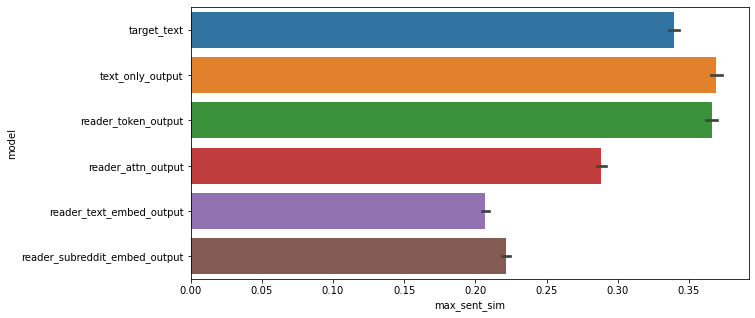

In [44]:
## flatten data lol
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
sent_sim_vars = [f'{x}_max_sim_sent_val' for x in target_text_vars]
flat_sent_sim_data = pd.melt(sample_combined_data.loc[:, sent_sim_vars], value_vars=sent_sim_vars, var_name='model', value_name='max_sent_sim')
flat_sent_sim_data = flat_sent_sim_data[flat_sent_sim_data.loc[:, 'max_sent_sim']<=max_sim_cutoff_val]
# clean model name
flat_sent_sim_data = flat_sent_sim_data.assign(**{
    'model' : flat_sent_sim_data.loc[:, 'model'].apply(lambda x: x.replace('_max_sim_sent_val', ''))
})
## plot everything
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=flat_sent_sim_data, y='model', x='max_sent_sim')
plt.show()

OK! The simplest models tend to produce answers with high similarity. That's not necessarily a bad thing for the other models!

Let's verify this on the data with reader tokens and the data with reader embeds.

In [47]:
def plot_sent_sim(data, target_text_vars):
    sent_sim_vars = [f'{x}_max_sim_sent_val' for x in target_text_vars]
    flat_sent_sim_data = pd.melt(data.loc[:, sent_sim_vars], value_vars=sent_sim_vars, var_name='model', value_name='max_sent_sim')
    flat_sent_sim_data = flat_sent_sim_data[flat_sent_sim_data.loc[:, 'max_sent_sim']<=max_sim_cutoff_val]
    # clean model name
    flat_sent_sim_data = flat_sent_sim_data.assign(**{
        'model' : flat_sent_sim_data.loc[:, 'model'].apply(lambda x: x.replace('_max_sim_sent_val', ''))
    })
    ## plot everything
    plt.figure(figsize=(10,5))
    sns.barplot(data=flat_sent_sim_data, y='model', x='max_sent_sim')
    plt.show()

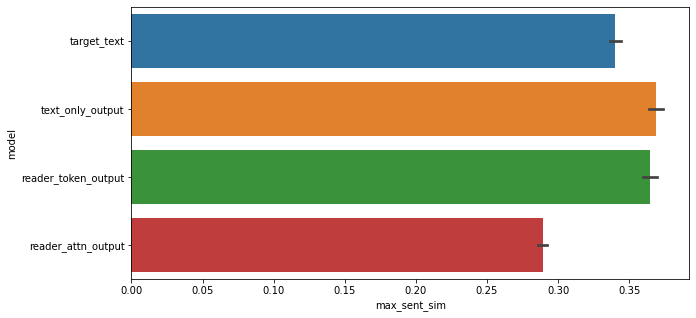

In [48]:
## reader tokens
sample_combined_data_with_reader_tokens = sample_combined_data[sample_combined_data.loc[:, 'reader_token']!='UNK']
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output']
plot_sent_sim(sample_combined_data_with_reader_tokens, target_text_vars)

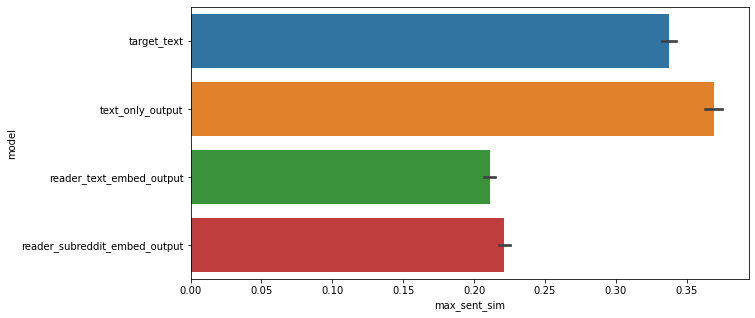

In [49]:
## reader embeds
sample_combined_data_with_embeds = sample_combined_data[sample_combined_data.loc[:, 'author_has_subreddit_embed'] & sample_combined_data.loc[:, 'author_has_text_embed']]
target_text_vars = ['target_text', 'text_only_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
plot_sent_sim(sample_combined_data_with_embeds, target_text_vars)

The model differences on the sub-set data are basically the same as the full data.

### Post overlap: topic

In [249]:
# optional: extract best vocab from all posts
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from stop_words import get_stop_words
en_stops = get_stop_words('en')
word_tokenizer = WordPunctTokenizer()
cv = CountVectorizer(min_df=0.0001, max_df=0.25, stop_words=en_stops, tokenizer=word_tokenizer.tokenize)
dtm = cv.fit_transform(combined_data.loc[:, 'source_text'].values)
# show top words
print(f'top words in docs')
print(pd.Series(np.array(dtm.sum(axis=0))[0], index=sorted(cv.vocabulary_, key=cv.vocabulary_.get)).sort_values(inplace=False, ascending=False).head(10))
dtm_vocab = set(cv.vocabulary_.keys())
# get corpus for LDA
from gensim.corpora import Dictionary
from nltk.tokenize import WordPunctTokenizer
word_tokenizer = WordPunctTokenizer()
source_text_tokens = combined_data.loc[:, 'source_text'].apply(lambda x: list(filter(lambda y: y in dtm_vocab, word_tokenizer.tokenize(x))))
lda_dict = Dictionary(source_text_tokens)
lda_corpus = source_text_tokens.apply(lda_dict.doc2bow).values
## find best # topics based on coherence
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
k_topics = [5, 10, 15, 20]
topic_metrics = []
for k_topic in k_topics:
    print(f'testing topics = {k_topic}')
    lda_model = LdaModel(lda_corpus, num_topics=k_topic, alpha='symmetric', iterations=100)
    print(f'computing coherence')
    coherence_model = CoherenceModel(model=lda_model, corpus=lda_corpus, texts=source_text_tokens, dictionary=lda_dict, coherence='c_v')
    coherence_k = coherence_model.get_coherence()
    topic_metrics.append(coherence_k)
topic_metrics = pd.Series(topic_metrics, index=k_topics)
print(topic_metrics)

top words in docs
$        43571
"        42040
:        26893
didn     23718
money    22976
;        22778
feel     22336
since    21575
think    20997
home     20821
dtype: int64
testing topics = 5
computing coherence
testing topics = 10
computing coherence
testing topics = 15
computing coherence
testing topics = 20
computing coherence
5     0.388676
10    0.420840
15    0.404000
20    0.387441
dtype: float64


In [250]:
optimal_k_topic = 10
lda_model = LdaModel(lda_corpus, num_topics=optimal_k_topic, alpha='symmetric', id2word=lda_dict, iterations=100)
# show top words per topic
lda_model.print_topics(num_words=10)

[(0,
  '0.038*"$" + 0.013*"money" + 0.012*"pay" + 0.010*"job" + 0.010*"month" + 0.008*"credit" + 0.008*"%" + 0.008*":" + 0.007*"debt" + 0.007*"000"'),
 (1,
  '0.021*""" + 0.009*"friends" + 0.008*"feel" + 0.008*"friend" + 0.008*"people" + 0.006*"didn" + 0.006*"think" + 0.006*"say" + 0.005*"something" + 0.005*"guy"'),
 (2,
  '0.013*"school" + 0.012*"parents" + 0.010*"son" + 0.010*"mother" + 0.009*"kids" + 0.008*"daughter" + 0.008*"family" + 0.007*""" + 0.006*"mom" + 0.006*"us"'),
 (3,
  '0.052*";" + 0.047*"amp" + 0.036*";#" + 0.026*"&" + 0.025*":" + 0.016*".&" + 0.012*"://" + 0.012*"com" + 0.011*"https" + 0.009*"**"'),
 (4,
  '0.016*"dog" + 0.009*""" + 0.009*"people" + 0.008*"water" + 0.008*"food" + 0.008*"day" + 0.006*"boss" + 0.006*")." + 0.005*"asked" + 0.005*"hours"'),
 (5,
  '0.014*"account" + 0.010*"dad" + 0.009*"sister" + 0.008*"mom" + 0.008*"help" + 0.007*"phone" + 0.007*"card" + 0.006*"tried" + 0.006*"check" + 0.006*"dont"'),
 (6,
  '0.010*"feel" + 0.009*"husband" + 0.008*"thing

These seem mainly split between `money` and `family` words, which makes sense.

In [264]:
# get topics for all documents
post_topics = lda_model.get_document_topics(lda_corpus, minimum_probability=0.)
post_topics = pd.DataFrame(list(map(lambda x: pd.Series(dict(x)), post_topics)))

(59273, 10)


,0,1,2,3,4,5,6,7,8,9
0,0.002861,0.002861,0.096314,0.571527,0.002861,0.071558,0.002861,0.243434,0.002861,0.002861
1,0.043867,0.000585,0.000585,0.000585,0.951453,0.000585,0.000585,0.000585,0.000585,0.000585
2,0.000505,0.000505,0.000505,0.000505,0.000505,0.923927,0.000505,0.000505,0.000505,0.072030
3,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.995158
4,0.000820,0.000820,0.000820,0.000820,0.000820,0.000820,0.992622,0.000820,0.000820,0.000820


In [280]:
## compute cosine similarity between post and question topics, for each post-question pair
from sklearn.metrics.pairwise import cosine_similarity
target_text_vars = ['target_text', 'text_only_output', 'reader_token_output', 'reader_attn_output', 'reader_text_embed_output', 'reader_subreddit_embed_output']
combined_data_topic_sims = []
for target_text_var in target_text_vars:
    print(f'testing topics for var={target_text_var}')
    question_lda_tokens = combined_data.loc[:, target_text_var].apply(lambda x: list(filter(lambda y: y in dtm_vocab, word_tokenizer.tokenize(x))))
    question_lda_corpus = question_lda_tokens.apply(lda_dict.doc2bow).values
    question_topics = lda_model.get_document_topics(question_lda_corpus, minimum_probability=0.)
    question_topics = pd.DataFrame(list(map(lambda x: pd.Series(dict(x)), question_topics)))
    post_question_sims = []
    for i in tqdm(range(post_topics.shape[0])):
        post_question_sim_i = cosine_similarity(post_topics.iloc[i, :].values.reshape(1,-1), question_topics.iloc[i, :].values.reshape(1,-1))[0][0]
        post_question_sims.append(post_question_sim_i)
    post_question_sims = pd.DataFrame(post_question_sims, columns=['post_question_topic_sim']).assign(**{'model' : target_text_var})
    combined_data_topic_sims.append(post_question_sims)
combined_data_topic_sims = pd.concat(combined_data_topic_sims, axis=0)

testing topics for var=target_text


100%|██████████| 59273/59273 [00:23<00:00, 2498.68it/s]


testing topics for var=text_only_output


100%|██████████| 59273/59273 [00:23<00:00, 2488.53it/s]


testing topics for var=reader_token_output


100%|██████████| 59273/59273 [00:25<00:00, 2338.64it/s]


testing topics for var=reader_attn_output


100%|██████████| 59273/59273 [00:27<00:00, 2178.75it/s]


testing topics for var=reader_text_embed_output


100%|██████████| 59273/59273 [00:26<00:00, 2242.06it/s]


testing topics for var=reader_subreddit_embed_output


100%|██████████| 59273/59273 [00:26<00:00, 2276.07it/s]


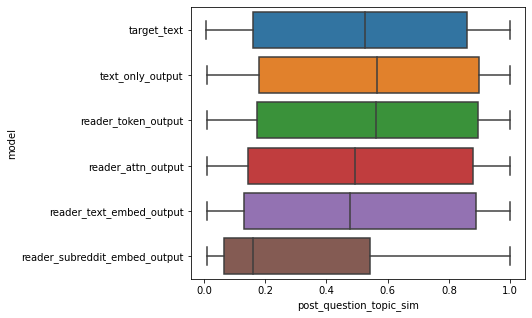

In [288]:
## plot post-topic sims
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,5))
sns.boxplot(data=combined_data_topic_sims, x='post_question_topic_sim', y='model')
plt.show()

OK! 

- The `text_only` model and `reader_token` model seem to "overfit" and produce text that is more topically similar than the actual questions.
- The `reader_attn` model and `text_embed` model are a bit closer to the expected value of topical similarity.